# 상태4종 2진분류 기울기 형성

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

# --------------------------------------------------------------------------------
# [설정] 컬럼명 및 파일 경로 설정
# --------------------------------------------------------------------------------
COL_ID = '발급회원번호'
COL_DATE = '기준년월'

# 분석 변수 (Wide Format의 접미사 '_MM' 등을 뗀 순수 컬럼명)
COL_SPEND = '이용금액_신용_B0M'      # 소비
COL_COUNT = '이용건수_신용_B0M'      # 빈도
COL_BALANCE = '잔액_B0M'             # 잔액
COL_CASH_ADV = '잔액_현금서비스_B0M' # 악성부채1
COL_CARD_LOAN = '잔액_카드론_B0M'    # 악성부채2
COL_DELINQ = '연체잔액_B0M'          # 리스크3
COL_AVG_BAL = '월중평잔'             # 자산

# --------------------------------------------------------------------------------
# [함수] 기울기 및 점수 계산 로직
# --------------------------------------------------------------------------------
def calc_slope_long(series):
    """시계열 데이터(Series)의 선형 회귀 기울기를 계산"""
    y = series.values.astype(float)
    if len(y) < 2 or np.sum(y) == 0:
        return 0
    x = np.arange(len(y))
    slope, _, _, _, _ = linregress(x, y)
    return 0 if np.isnan(slope) else slope

def calculate_churn_scores(group):
    """고객 한 명의 6개월치 데이터를 받아 점수 계산"""
    # 데이터가 6개월 미만인 경우 0으로 채워서 반환
    if len(group) < 6:
        return pd.Series({
            'Score_BadDebt': 0, 'Score_Delinq': 0, 'Score_Activity': 0, 'Score_Asset': 0,
            'Score_Status_Total': 0, 'Slope_Spend': 0, 'Slope_Balance': 0, 'Slope_Count': 0
        })

    # (A) 상태 점수 (Status Score) 세부 항목 계산
    
    # 1. [부정] 악성 부채 점수 (Score_BadDebt)
    bad_debt_score = (
        ((group[COL_CASH_ADV].iloc[-1] - group[COL_CASH_ADV].iloc[-2]) / (group[COL_CASH_ADV].iloc[-2] + 1) * 1.5) +
        ((group[COL_CARD_LOAN].iloc[-1] - group[COL_CARD_LOAN].iloc[-2]) / (group[COL_CARD_LOAN].iloc[-2] + 1) * 1.0)
    )
    
    # 2. [부정] 연체 강도 점수 (Score_Delinq)
    delinq_score = (
        (group[COL_DELINQ].iloc[-1] * 3.0) +
        (group[COL_DELINQ].iloc[-2] * 2.0) +
        (group[COL_DELINQ].iloc[-3] * 1.0)
    )
    
    # 3. [긍정] 활동성 점수 (Score_Activity)
    sum_r3 = group[COL_COUNT].iloc[-3:].sum()
    sum_r6 = group[COL_COUNT].sum()
    activity_score = ((sum_r3 * 2) - sum_r6) / (sum_r6 + 1) * 100
    
    # 4. [긍정] 자산 방어 점수 (Score_Asset)
    avg_r3 = group[COL_AVG_BAL].iloc[-3:].mean()
    avg_r6 = group[COL_AVG_BAL].mean()
    asset_score = (avg_r3 / (avg_r6 + 1)) * 10
    
    # >> [Total] 상태 종합 점수 (Score_Status_Total)
    score_status_total = (bad_debt_score + delinq_score) - (activity_score + asset_score)
    
    # (B) 기울기 점수 (Slope Score)
    slope_spend = calc_slope_long(group[COL_SPEND])
    slope_balance = calc_slope_long(group[COL_BALANCE])
    slope_count = calc_slope_long(group[COL_COUNT])
    
    # [Final 파일과 동일한 컬럼 구성으로 반환]
    return pd.Series({
        'Score_BadDebt': bad_debt_score,
        'Score_Delinq': delinq_score,
        'Score_Activity': activity_score,
        'Score_Asset': asset_score,
        'Score_Status_Total': score_status_total,
        'Slope_Spend': slope_spend,
        'Slope_Balance': slope_balance,
        'Slope_Count': slope_count
    })

# =============================================================================
# [실행] 메인 프로세스
# =============================================================================

# 1. 데이터 로드
file_path = '../30만원본/GENERAL_30K_merged_data_240636_822.csv' 
print(f"파일을 로드합니다: {file_path}")
df = pd.read_csv(file_path)

# 2. 컬럼 순서 재배치 (발급회원번호 -> 기준년월 -> 나머지)
cols = df.columns.tolist()
if COL_ID in cols and COL_DATE in cols:
    remain_cols = [c for c in cols if c not in [COL_ID, COL_DATE]]
    df = df[[COL_ID, COL_DATE] + remain_cols]

# 3. 데이터 정렬 및 그룹별 연산
df.sort_values(by=[COL_ID, COL_DATE], inplace=True)

print("4. 고객별 지표 산출 중... (시간이 소요됩니다)")
# groupby 결과를 df에 할당 (고객 단위 데이터프레임)
df = df.groupby(COL_ID).apply(calculate_churn_scores).reset_index()

# 5. 점수 정규화 및 최종 산출
scaler = MinMaxScaler()

def normalize_risk_vector(series):
    series = series.replace([np.inf, -np.inf], 0).fillna(0)
    # 감소(-)하는 기울기만 위험으로 간주하여 양수로 변환
    risk = series.apply(lambda x: -x if x < 0 else 0)
    return scaler.fit_transform(risk.values.reshape(-1, 1)).flatten()

# 기울기 리스크 점수화 (Norm_...)
df['Norm_Slope_Spend'] = normalize_risk_vector(df['Slope_Spend'])
df['Norm_Slope_Balance'] = normalize_risk_vector(df['Slope_Balance'])
df['Norm_Slope_Count'] = normalize_risk_vector(df['Slope_Count'])

# 기울기 종합 점수 (Score_Slope_Total)
df['Score_Slope_Total'] = (
    (df['Norm_Slope_Spend'] * 40) +
    (df['Norm_Slope_Balance'] * 30) +
    (df['Norm_Slope_Count'] * 30)
)

# 상태 점수 Infinity 처리
df['Score_Status_Total'] = df['Score_Status_Total'].replace([np.inf, -np.inf], 0).fillna(0)

# 최종 합산 점수 (Final_Total_Score)
df['Final_Total_Score'] = (df['Score_Status_Total'] + df['Score_Slope_Total']) * 0.5

print("✅ 최종 작업 완료!")
# 결과 확인 (세부 점수 포함)
print(df[[COL_ID, 'Final_Total_Score', 'Score_Status_Total', 'Score_BadDebt', 'Score_Activity']].head())



파일을 로드합니다: ../30만원본/GENERAL_30K_merged_data_240636_822.csv


C:\Users\johnh\AppData\Local\Temp\ipykernel_10364\2530321616.py:96: DtypeWarning: Columns (254) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


4. 고객별 지표 산출 중... (시간이 소요됩니다)


C:\Users\johnh\AppData\Local\Temp\ipykernel_10364\2530321616.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  activity_score = ((sum_r3 * 2) - sum_r6) / (sum_r6 + 1) * 100


✅ 최종 작업 완료!
        발급회원번호  Final_Total_Score  Score_Status_Total  Score_BadDebt  \
0  SYN_1000048         -10.674369          -21.348738            0.0   
1  SYN_1000194         -25.729657          -57.219573            0.0   
2  SYN_1000201          18.559508           26.484019            0.0   
3  SYN_1000250           1.822382            0.000000            0.0   
4  SYN_1000338          43.906651           79.781461            0.0   

   Score_Activity  
0       12.021858  
1       45.833333  
2      -37.209302  
3            -inf  
4      -91.666667  


C:\Users\johnh\AppData\Local\Temp\ipykernel_10364\2530321616.py:109: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(COL_ID).apply(calculate_churn_scores).reset_index()


### 파생변수 분포 확인

c:\Users\johnh\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\_core\_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


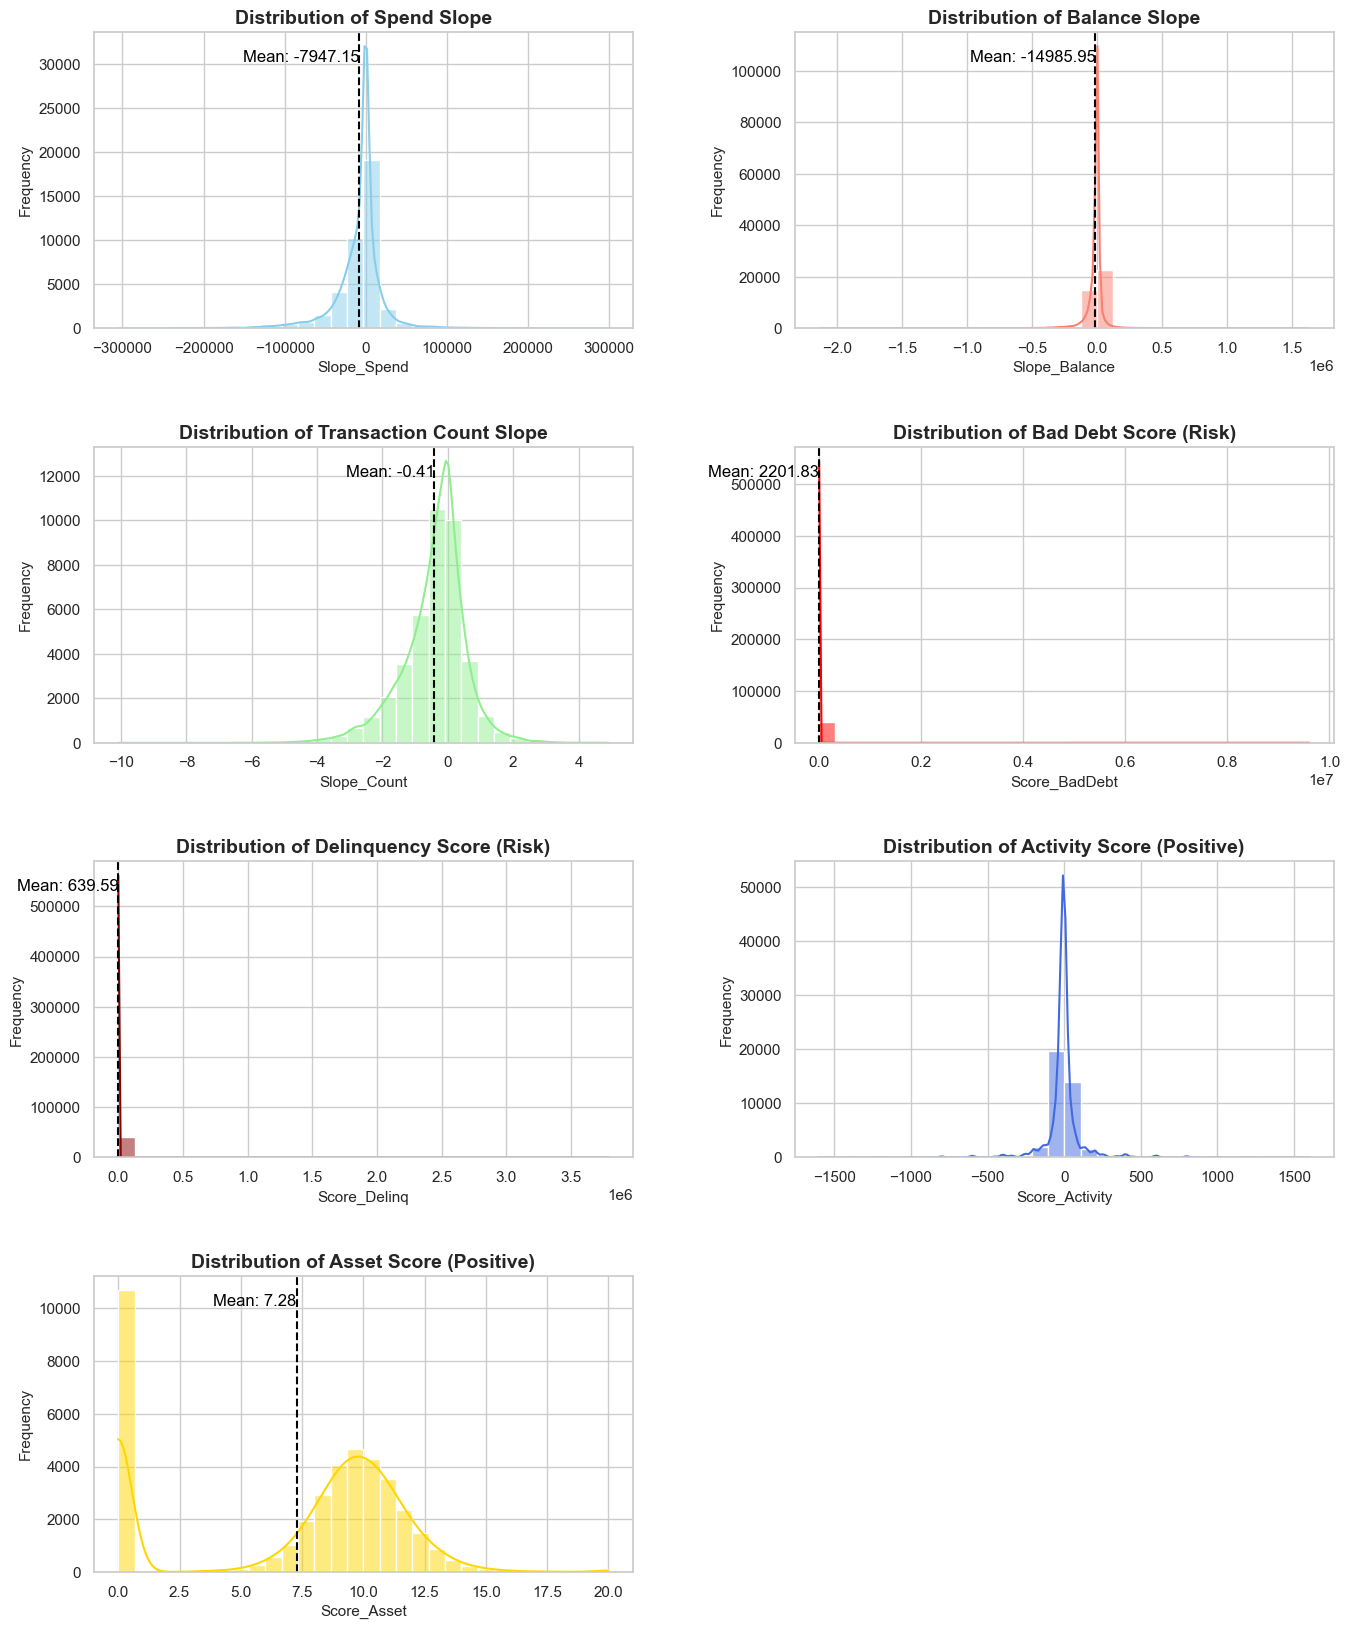

📊 7대 주요 지표 분포 시각화 완료


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# =============================================================================
# [시각화] 주요 변수 7종 분포 확인 (Visualization)
# =============================================================================

# 1. 그래프 스타일 및 캔버스 설정
sns.set(style="whitegrid")

# 4행 2열의 서브플롯 생성 (총 8개 공간, 7개 변수 사용)
fig, axes = plt.subplots(4, 2, figsize=(16, 20))
plt.subplots_adjust(hspace=0.4, wspace=0.3) # 그래프 간 간격 조정

# 변수 목록 및 제목 매핑
vars_to_plot = [
    ('Slope_Spend', 'Distribution of Spend Slope', 'skyblue'),
    ('Slope_Balance', 'Distribution of Balance Slope', 'salmon'),
    ('Slope_Count', 'Distribution of Transaction Count Slope', 'lightgreen'),
    ('Score_BadDebt', 'Distribution of Bad Debt Score (Risk)', 'red'),
    ('Score_Delinq', 'Distribution of Delinquency Score (Risk)', 'darkred'),
    ('Score_Activity', 'Distribution of Activity Score (Positive)', 'royalblue'),
    ('Score_Asset', 'Distribution of Asset Score (Positive)', 'gold')
]

# 2. 반복문을 통해 그래프 생성
flat_axes = axes.flatten() # 2차원 배열을 1차원으로 펼침

for i, (col, title, color) in enumerate(vars_to_plot):
    ax = flat_axes[i]
    
    # 히스토그램 & KDE(밀도) 그래프 그리기
    sns.histplot(data=df, x=col, kde=True, ax=ax, color=color, bins=30)
    
    # 그래프 꾸미기
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel(col, fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    
    # 평균선 추가 (점선)
    mean_val = df[col].mean()
    ax.axvline(mean_val, color='black', linestyle='--', linewidth=1.5)
    ax.text(mean_val, ax.get_ylim()[1]*0.9, f'Mean: {mean_val:.2f}', color='black', ha='right')

# 3. 남는 칸(8번째) 숨기기 및 레이아웃 정리
if len(vars_to_plot) < len(flat_axes):
    for j in range(len(vars_to_plot), len(flat_axes)):
        fig.delaxes(flat_axes[j])

# 그래프 출력
plt.show()

print("📊 7대 주요 지표 분포 시각화 완료")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40106 entries, 0 to 40105
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   발급회원번호              40106 non-null  object 
 1   Score_BadDebt       40106 non-null  float64
 2   Score_Delinq        40106 non-null  float64
 3   Score_Activity      40106 non-null  float64
 4   Score_Asset         40106 non-null  float64
 5   Score_Status_Total  40106 non-null  float64
 6   Slope_Spend         40106 non-null  float64
 7   Slope_Balance       40106 non-null  float64
 8   Slope_Count         40106 non-null  float64
 9   Norm_Slope_Spend    40106 non-null  float64
 10  Norm_Slope_Balance  40106 non-null  float64
 11  Norm_Slope_Count    40106 non-null  float64
 12  Score_Slope_Total   40106 non-null  float64
 13  Final_Total_Score   40106 non-null  float64
dtypes: float64(13), object(1)
memory usage: 4.3+ MB


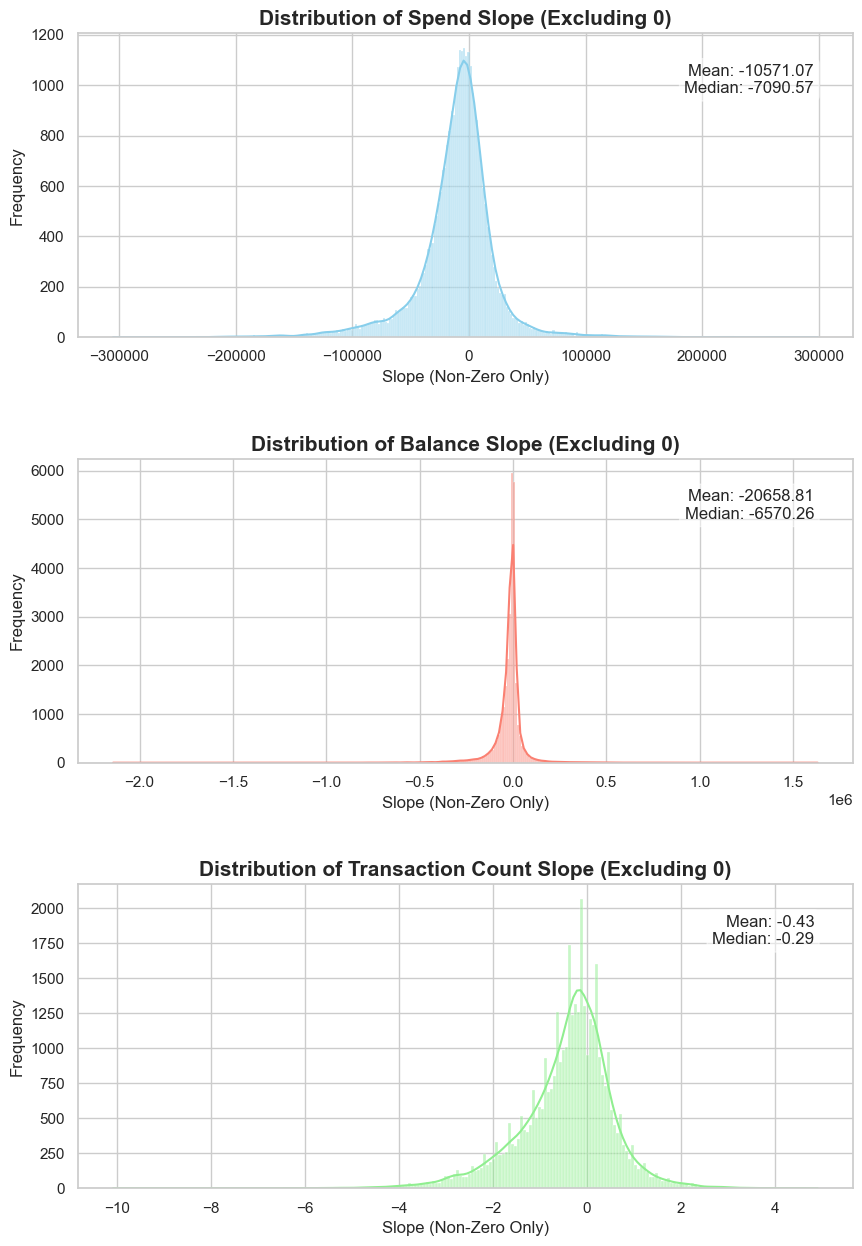

📊 0값 제외 그래프 생성이 완료되었습니다.
   - 전체 데이터 수: 40106
   - 0 제외 데이터 수 확인:
     * Slope_Spend: 30151 건 (0값: 9955 건)
     * Slope_Balance: 29093 건 (0값: 11013 건)
     * Slope_Count: 38801 건 (0값: 1305 건)


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# =============================================================================
# [Step 5] 0값 제외(Zero-Excluded) 기울기 분포 시각화
# =============================================================================

# 1. 스타일 설정
sns.set(style="whitegrid")

# 2. 캔버스 생성 (3행 1열)
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
plt.subplots_adjust(hspace=0.4)

# 분석할 변수와 제목 리스트 정의
slope_vars = [
    ('Slope_Spend', 'Spend Slope (Excluding 0)', 'skyblue'),
    ('Slope_Balance', 'Balance Slope (Excluding 0)', 'salmon'),
    ('Slope_Count', 'Transaction Count Slope (Excluding 0)', 'lightgreen')
]

for i, (col, title, color) in enumerate(slope_vars):
    # ---------------------------------------------------------
    # 핵심 로직: 값이 0이 아닌 데이터만 필터링
    # ----------------------------------------- ----------------
    data_nonzero = df[df[col] != 0]
    
    # 데이터가 비어있지 않은 경우에만 플롯
    if not data_nonzero.empty:
        sns.histplot(data=data_nonzero, x=col, kde=True, ax=axes[i], color=color)
        
        # 제목 및 축 설정
        axes[i].set_title(f'Distribution of {title}', fontsize=15, fontweight='bold')
        axes[i].set_xlabel('Slope (Non-Zero Only)', fontsize=12)
        axes[i].set_ylabel('Frequency', fontsize=12)
        
        # 통계량 표시 (평균, 중앙값) - 그래프 안에 텍스트로 추가
        mean_val = data_nonzero[col].mean()
        median_val = data_nonzero[col].median()
        stats_text = f'Mean: {mean_val:.2f}\nMedian: {median_val:.2f}'
        
        # 텍스트 박스 추가 (그래프 우측 상단)
        axes[i].text(0.95, 0.9, stats_text, transform=axes[i].transAxes, 
                     fontsize=12, verticalalignment='top', horizontalalignment='right',
                     bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    else:
        axes[i].text(0.5, 0.5, 'No Non-Zero Data', horizontalalignment='center', verticalalignment='center')
        axes[i].set_title(f'Distribution of {title}', fontsize=15, fontweight='bold')

# 3. 저장 및 출력
# plt.savefig('Slope_Distributions_NonZero.png', dpi=300)
plt.show()

print(f"📊 0값 제외 그래프 생성이 완료되었습니다.\n   - 전체 데이터 수: {len(df)}\n   - 0 제외 데이터 수 확인:")
for col, _, _ in slope_vars:
    print(f"     * {col}: {len(df[df[col] != 0])} 건 (0값: {len(df[df[col] == 0])} 건)")

In [5]:
# =============================================================================
# [Step 6] 기울기 감소/유지(<=0) 비율 확인
# =============================================================================

total_count = len(df)
print(f"📊 전체 데이터 수: {total_count:,}건\n")

# 1. 소비(Spend) 기울기 0 이하 비율
cnt_spend_le0 = len(df[df['Slope_Spend'] <= 0])
ratio_spend = (cnt_spend_le0 / total_count) * 100
print(f"1. 소비 감소/유지 (Spend <= 0): {ratio_spend:.2f}% ({cnt_spend_le0:,}건)")

# 2. 잔액(Balance) 기울기 0 이하 비율
cnt_balance_le0 = len(df[df['Slope_Balance'] <= 0])
ratio_balance = (cnt_balance_le0 / total_count) * 100
print(f"2. 잔액 감소/유지 (Balance <= 0): {ratio_balance:.2f}% ({cnt_balance_le0:,}건)")

# 3. 빈도(Count) 기울기 0 이하 비율
cnt_count_le0 = len(df[df['Slope_Count'] <= 0])
ratio_count = (cnt_count_le0 / total_count) * 100
print(f"3. 빈도 감소/유지 (Count <= 0) : {ratio_count:.2f}% ({cnt_count_le0:,}건)")

print("-" * 50)

# 4. [핵심] 3가지 지표 모두 0 이하인 경우 (교집합)
# 이들은 소비도 줄고, 잔액도 줄고, 발길(빈도)도 끊고 있는 '완전 이탈 징후' 고객군입니다.
df_all_le0 = df[
    (df['Slope_Spend'] <= 0) & 
    (df['Slope_Balance'] <= 0) & 
    (df['Slope_Count'] <= 0)
]
cnt_all_le0 = len(df_all_le0)
ratio_all = (cnt_all_le0 / total_count) * 100

print(f"🚨 4. 3가지 모두 감소/유지 (All <= 0): {ratio_all:.2f}% ({cnt_all_le0:,}건)")

📊 전체 데이터 수: 40,106건

1. 소비 감소/유지 (Spend <= 0): 73.42% (29,447건)
2. 잔액 감소/유지 (Balance <= 0): 74.98% (30,071건)
3. 빈도 감소/유지 (Count <= 0) : 67.62% (27,119건)
--------------------------------------------------
🚨 4. 3가지 모두 감소/유지 (All <= 0): 44.09% (17,684건)


In [6]:
# =============================================================================
# [Step A] 활동성 점수(Score_Activity) 분포 및 분위수 진단
# =============================================================================

# 1. 분위수(Quantile) 통계량 계산
# 하위 10%부터 50%까지 10% 단위로 끊어서 점수 확인
pct_range = [0.1, 0.2, 0.3, 0.4, 0.5]
quantiles_all = df['Score_Activity'].quantile(pct_range)

print("\n[전체 데이터 기준 하위 % 점수]")
for q, val in zip(pct_range, quantiles_all):
    print(f" - 하위 {int(q*100)}%: {val:.2f} 점")

# 감소한 사람(음수)들 중에서만 다시 분위수 확인 (더 정밀한 타겟팅용)
df_neg = df[df['Score_Activity'] < 0]
if not df_neg.empty:
    quantiles_neg = df_neg['Score_Activity'].quantile(pct_range)
    print("\n[활동성 감소(음수) 집단 내 하위 % 점수]")
    for q, val in zip(pct_range, quantiles_neg):
        print(f" - 하위 {int(q*100)}%: {val:.2f} 점")
else:
    quantiles_neg = []
    print("\n⚠️ 활동성 점수가 음수인 데이터가 없습니다.")

# #---------------------------------------------------------
# # 2. 시각화 (Visualization)
# # ---------------------------------------------------------
# sns.set(style="whitegrid")
# fig, axes = plt.subplots(2, 1, figsize=(12, 14))
# plt.subplots_adjust(hspace=0.4)

# # (1) 전체 분포 확인
# sns.histplot(data=df, x='Score_Activity', kde=True, ax=axes[0], color='royalblue', bins=50)
# axes[0].set_title('1. Distribution of Activity Score (All Customers)', fontsize=15, fontweight='bold')
# axes[0].set_xlabel('Score', fontsize=12)

# # 전체 기준 분위수 라인 표시
# for q, val in zip(pct_range, quantiles_all):
#     axes[0].axvline(val, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
#     axes[0].text(val, axes[0].get_ylim()[1]*0.95, f'{int(q*100)}%', color='red', ha='right', fontweight='bold', rotation=90)


# # (2) 감소 집단(음수) 상세 분포 확인 (Zoom-In)
# if not df_neg.empty:
#     sns.histplot(data=df_neg, x='Score_Activity', kde=True, ax=axes[1], color='darkorange', bins=30)
#     axes[1].set_title('2. Distribution of Activity Drop (Negative Score Only)', fontsize=15, fontweight='bold')
#     axes[1].set_xlabel('Negative Score (Drop Intensity)', fontsize=12)

#     # 음수 집단 기준 분위수 라인 표시
#     for q, val in zip(pct_range, quantiles_neg):
#         axes[1].axvline(val, color='darkred', linestyle='--', linewidth=1.5, alpha=0.7)
#         axes[1].text(val, axes[1].get_ylim()[1]*0.95, f'Bottom {int(q*100)}%', color='darkred', ha='right', fontweight='bold', rotation=90)
        
#     # 통계 박스 추가
#     stats_txt = f'Count: {len(df_neg):,}\nMean: {df_neg["Score_Activity"].mean():.2f}\nMin: {df_neg["Score_Activity"].min():.2f}'
#     axes[1].text(0.02, 0.95, stats_txt, transform=axes[1].transAxes, fontsize=12,
#                  verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# else:
#     axes[1].text(0.5, 0.5, "No Negative Score Data", ha='center', fontsize=15)

# # 저장 및 출력
# # plt.savefig('Activity_Score_Quantile_Analysis.png', dpi=300)
# plt.show()

# print("📊 그래프가 생성되었습니다. 붉은 점선이 하위 % 지점입니다.")


[전체 데이터 기준 하위 % 점수]
 - 하위 10%: -83.33 점
 - 하위 20%: -36.36 점
 - 하위 30%: -19.17 점
 - 하위 40%: -10.65 점
 - 하위 50%: -4.62 점

[활동성 감소(음수) 집단 내 하위 % 점수]
 - 하위 10%: -160.00 점
 - 하위 20%: -70.11 점
 - 하위 30%: -42.59 점
 - 하위 40%: -28.57 점
 - 하위 50%: -20.69 점


### True/False Decision Tree 생성

In [7]:
# (안전장치) df_all_le0가 정의되어 있는지 확인
# if 'df_all_le0' not in locals():
#     print("⚠️ df_all_le0 데이터를 다시 생성합니다.")
#     df_all_le0 = df[
#         (df['Slope_Spend'] <= 0) & 
#         (df['Slope_Balance'] <= 0) & 
#         (df['Slope_Count'] <= 0)
#     ].copy()

# print(f"대상 데이터 수: {len(df_all_le0):,}명")
# print("-" * 50)

# =============================================================================
# [Step 1] 조건 Flag 생성 (True = Risk/Signal 로 통일)
# =============================================================================

# 1. [반전] 악성 부채 점수가 있는가? (0이 아니면 True)
# -> 부채가 급증했거나(양수), 급감(음수)하는 등 변동이 있는 상태
df_all_le0['Cond1_Has_BadDebt'] = df_all_le0['Score_BadDebt'] > 0

# 2. [반전] 연체 점수가 있는가? (0이 아니면 True)
# -> 연체가 조금이라도 있는 상태
df_all_le0['Cond2_Has_Delinq'] = df_all_le0['Score_Delinq'] > 0

# 3. [유지] 활동성이 감소했는가? (음수면 True)
df_all_le0['Cond3_Activity_Drop'] = df_all_le0['Score_Activity'] < 0

# 4. [유지] 자산 점수가 0인가? (0이면 True)
df_all_le0['Cond4_Asset_Zero'] = df_all_le0['Score_Asset'] == 0


# =============================================================================
# [Step 2] 고객 유형 세분화 (Segmentation)
# =============================================================================

def classify_churn_type_v2(row):
    # 논리가 'True = 위험'으로 바뀌었으므로 코드가 더 직관적으로 변함
    
    # 1순위: 부실/연체 위험군 (악성부채나 연체 점수가 '있으면' 해당)
    if row['Cond1_Has_BadDebt'] or row['Cond2_Has_Delinq']:
        return '1. 부실/연체 위험군 (Risk)'
    
    # 2순위: 이탈 완료 의심군 (자산 점수가 0이면 해당)
    if row['Cond4_Asset_Zero']:
        return '2. 이탈 완료 의심군 (Empty Asset)'
    
    # 3순위: 활동성 급감군 (활동성 점수가 음수이면 해당)
    if row['Cond3_Activity_Drop']:
        return '3. 활동성 급감군 (Activity Drop)'
    
    # 4순위: 그 외 (기울기는 줄었지만, 위 3가지 심각한 징후는 없는 경우)
    return '4. 단순 감소/유지군 (Soft Decline)'

# 분류 적용
df_all_le0['Churn_Segment'] = df_all_le0.apply(classify_churn_type_v2, axis=1)

# =============================================================================
# [Step 3] 결과 집계
# =============================================================================

# 1. 각 Risk 조건별 감지 인원 (True 개수)
print("\n[Risk 요인별 감지 인원 (True 기준)]")
print(f"1. 악성부채 징후 (Score!=0) : {df_all_le0['Cond1_Has_BadDebt'].sum():,}명")
print(f"2. 연체 징후 (Score!=0)     : {df_all_le0['Cond2_Has_Delinq'].sum():,}명")
print(f"3. 활동성 감소 (Score<0)    : {df_all_le0['Cond3_Activity_Drop'].sum():,}명")
print(f"4. 자산 이탈 (Score=0)      : {df_all_le0['Cond4_Asset_Zero'].sum():,}명")

# 2. 최종 세그먼트 분포
segment_counts = df_all_le0['Churn_Segment'].value_counts()
segment_ratio = df_all_le0['Churn_Segment'].value_counts(normalize=True) * 100

print("\n[최종 고객 유형 분류 결과]")
result_df = pd.DataFrame({'인원수': segment_counts, '비율(%)': segment_ratio})
# 인덱스 정렬 (1번 그룹부터 순서대로 보이게)
result_df = result_df.sort_index()
print(result_df)

# 샘플 데이터 확인
print("\n[데이터 샘플]")
cols_check = ['발급회원번호', 'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero', 'Churn_Segment']
print(df_all_le0[cols_check].head())


[Risk 요인별 감지 인원 (True 기준)]
1. 악성부채 징후 (Score!=0) : 352명
2. 연체 징후 (Score!=0)     : 12명
3. 활동성 감소 (Score<0)    : 12,048명
4. 자산 이탈 (Score=0)      : 5,881명

[최종 고객 유형 분류 결과]
                              인원수      비율(%)
Churn_Segment                               
1. 부실/연체 위험군 (Risk)           363   2.052703
2. 이탈 완료 의심군 (Empty Asset)   5880  33.250396
3. 활동성 급감군 (Activity Drop)   9673  54.699163
4. 단순 감소/유지군 (Soft Decline)  1768   9.997738

[데이터 샘플]
         발급회원번호  Cond1_Has_BadDebt  Cond2_Has_Delinq  Cond3_Activity_Drop  \
2   SYN_1000201              False             False                 True   
3   SYN_1000250              False             False                 True   
4   SYN_1000338              False             False                 True   
8    SYN_100058              False             False                 True   
14  SYN_1000994              False             False                 True   

    Cond4_Asset_Zero               Churn_Segment  
2              False  3. 활동성 급감군 (A

C:\Users\johnh\AppData\Local\Temp\ipykernel_10364\1414906714.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_le0['Cond1_Has_BadDebt'] = df_all_le0['Score_BadDebt'] > 0
C:\Users\johnh\AppData\Local\Temp\ipykernel_10364\1414906714.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_le0['Cond2_Has_Delinq'] = df_all_le0['Score_Delinq'] > 0
C:\Users\johnh\AppData\Local\Temp\ipykernel_10364\1414906714.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [8]:
# =============================================================================
# [Step 4] 위험 요인 개수 산출 (Risk Intensity Scoring)
# =============================================================================

# 4가지 조건 컬럼 리스트
risk_cols = ['Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero']

# 행(Row)별로 True(1)의 개수를 합산
df_all_le0['Risk_Count'] = df_all_le0[risk_cols].sum(axis=1)

# 결과 확인
print("\n[위험 요인 개수별 인원 분포]")
count_dist = df_all_le0['Risk_Count'].value_counts().sort_index()
print(count_dist)

print("\n[비율(%)]")
print((df_all_le0['Risk_Count'].value_counts(normalize=True).sort_index() * 100).round(2))

# 샘플 데이터 확인 (잘 들어갔는지)
print("\n[데이터 샘플]")
print(df_all_le0[['발급회원번호', 'Risk_Count', 'Churn_Segment']].head())


[위험 요인 개수별 인원 분포]
Risk_Count
0     1768
1    13540
2     2375
3        1
Name: count, dtype: int64

[비율(%)]
Risk_Count
0    10.00
1    76.57
2    13.43
3     0.01
Name: proportion, dtype: float64

[데이터 샘플]
         발급회원번호  Risk_Count               Churn_Segment
2   SYN_1000201           1  3. 활동성 급감군 (Activity Drop)
3   SYN_1000250           1  3. 활동성 급감군 (Activity Drop)
4   SYN_1000338           1  3. 활동성 급감군 (Activity Drop)
8    SYN_100058           1  3. 활동성 급감군 (Activity Drop)
14  SYN_1000994           1  3. 활동성 급감군 (Activity Drop)


C:\Users\johnh\AppData\Local\Temp\ipykernel_10364\1207309625.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_all_le0['Risk_Count'] = df_all_le0[risk_cols].sum(axis=1)


### Target 형성 (이탈자)

In [9]:
df_all_le0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17684 entries, 2 to 40105
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   발급회원번호               17684 non-null  object 
 1   Score_BadDebt        17684 non-null  float64
 2   Score_Delinq         17684 non-null  float64
 3   Score_Activity       17684 non-null  float64
 4   Score_Asset          17684 non-null  float64
 5   Score_Status_Total   17684 non-null  float64
 6   Slope_Spend          17684 non-null  float64
 7   Slope_Balance        17684 non-null  float64
 8   Slope_Count          17684 non-null  float64
 9   Norm_Slope_Spend     17684 non-null  float64
 10  Norm_Slope_Balance   17684 non-null  float64
 11  Norm_Slope_Count     17684 non-null  float64
 12  Score_Slope_Total    17684 non-null  float64
 13  Final_Total_Score    17684 non-null  float64
 14  Cond1_Has_BadDebt    17684 non-null  bool   
 15  Cond2_Has_Delinq     17684 non-null  bool

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40106 entries, 0 to 40105
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   발급회원번호              40106 non-null  object 
 1   Score_BadDebt       40106 non-null  float64
 2   Score_Delinq        40106 non-null  float64
 3   Score_Activity      40106 non-null  float64
 4   Score_Asset         40106 non-null  float64
 5   Score_Status_Total  40106 non-null  float64
 6   Slope_Spend         40106 non-null  float64
 7   Slope_Balance       40106 non-null  float64
 8   Slope_Count         40106 non-null  float64
 9   Norm_Slope_Spend    40106 non-null  float64
 10  Norm_Slope_Balance  40106 non-null  float64
 11  Norm_Slope_Count    40106 non-null  float64
 12  Score_Slope_Total   40106 non-null  float64
 13  Final_Total_Score   40106 non-null  float64
dtypes: float64(13), object(1)
memory usage: 4.3+ MB


#### df 에 Risk_Count 추가

In [11]:
# (안전장치) df_all_le0가 정의되어 있는지 확인
# if 'df_all_le0' not in locals():
#     print("⚠️ df_all_le0 데이터를 다시 생성합니다.")
#     df_all_le0 = df[
#         (df['Slope_Spend'] <= 0) & 
#         (df['Slope_Balance'] <= 0) & 
#         (df['Slope_Count'] <= 0)
#     ].copy()

# print(f"대상 데이터 수: {len(df_all_le0):,}명")
# print("-" * 50)

# =============================================================================
# [Step 1] 조건 Flag 생성 (True = Risk/Signal 로 통일)
# =============================================================================

# 1. [반전] 악성 부채 점수가 있는가? (0이 아니면 True)
# -> 부채가 급증했거나(양수), 급감(음수)하는 등 변동이 있는 상태
df['Cond1_Has_BadDebt'] = df['Score_BadDebt'] > 0

# 2. [반전] 연체 점수가 있는가? (0이 아니면 True)
# -> 연체가 조금이라도 있는 상태
df['Cond2_Has_Delinq'] = df['Score_Delinq'] > 0

# 3. [유지] 활동성이 감소했는가? (음수면 True)
df['Cond3_Activity_Drop'] = df['Score_Activity'] < 0

# 4. [유지] 자산 점수가 0인가? (0이면 True)
df['Cond4_Asset_Zero'] = df['Score_Asset'] == 0


# =============================================================================
# [Step 2] 고객 유형 세분화 (Segmentation)
# =============================================================================

def classify_churn_type_v2(row):
    # 논리가 'True = 위험'으로 바뀌었으므로 코드가 더 직관적으로 변함
    
    # 1순위: 부실/연체 위험군 (악성부채나 연체 점수가 '있으면' 해당)
    if row['Cond1_Has_BadDebt'] or row['Cond2_Has_Delinq']:
        return '1. 부실/연체 위험군 (Risk)'
    
    # 2순위: 이탈 완료 의심군 (자산 점수가 0이면 해당)
    if row['Cond4_Asset_Zero']:
        return '2. 이탈 완료 의심군 (Empty Asset)'
    
    # 3순위: 활동성 급감군 (활동성 점수가 음수이면 해당)
    if row['Cond3_Activity_Drop']:
        return '3. 활동성 급감군 (Activity Drop)'
    
    # 4순위: 그 외 (기울기는 줄었지만, 위 3가지 심각한 징후는 없는 경우)
    return '4. 단순 감소/유지군 (Soft Decline)'

# 분류 적용
df['Churn_Segment'] = df.apply(classify_churn_type_v2, axis=1)

# =============================================================================
# [Step 3] 결과 집계
# =============================================================================

# 1. 각 Risk 조건별 감지 인원 (True 개수)
print("\n[Risk 요인별 감지 인원 (True 기준)]")
print(f"1. 악성부채 징후 (Score!=0) : {df['Cond1_Has_BadDebt'].sum():,}명")
print(f"2. 연체 징후 (Score!=0)     : {df['Cond2_Has_Delinq'].sum():,}명")
print(f"3. 활동성 감소 (Score<0)    : {df['Cond3_Activity_Drop'].sum():,}명")
print(f"4. 자산 이탈 (Score=0)      : {df['Cond4_Asset_Zero'].sum():,}명")

# 2. 최종 세그먼트 분포
segment_counts = df['Churn_Segment'].value_counts()
segment_ratio = df['Churn_Segment'].value_counts(normalize=True) * 100

print("\n[최종 고객 유형 분류 결과]")
result_df = pd.DataFrame({'인원수': segment_counts, '비율(%)': segment_ratio})
# 인덱스 정렬 (1번 그룹부터 순서대로 보이게)
result_df = result_df.sort_index()
print(result_df)

# 샘플 데이터 확인
print("\n[데이터 샘플]")
cols_check = ['발급회원번호', 'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero', 'Churn_Segment']
print(df[cols_check].head())


[Risk 요인별 감지 인원 (True 기준)]
1. 악성부채 징후 (Score!=0) : 1,382명
2. 연체 징후 (Score!=0)     : 37명
3. 활동성 감소 (Score<0)    : 23,264명
4. 자산 이탈 (Score=0)      : 10,699명

[최종 고객 유형 분류 결과]
                               인원수      비율(%)
Churn_Segment                                
1. 부실/연체 위험군 (Risk)           1413   3.523164
2. 이탈 완료 의심군 (Empty Asset)   10697  26.671820
3. 활동성 급감군 (Activity Drop)   17696  44.123074
4. 단순 감소/유지군 (Soft Decline)  10300  25.681943

[데이터 샘플]
        발급회원번호  Cond1_Has_BadDebt  Cond2_Has_Delinq  Cond3_Activity_Drop  \
0  SYN_1000048              False             False                False   
1  SYN_1000194              False             False                False   
2  SYN_1000201              False             False                 True   
3  SYN_1000250              False             False                 True   
4  SYN_1000338              False             False                 True   

   Cond4_Asset_Zero                Churn_Segment  
0             False  4. 단순 감소/유지

In [12]:
# =============================================================================
# [Step 4] 위험 요인 개수 산출 (Risk Intensity Scoring)
# =============================================================================

# 4가지 조건 컬럼 리스트
risk_cols = ['Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero']

# 행(Row)별로 True(1)의 개수를 합산
df['Risk_Count'] = df[risk_cols].sum(axis=1)

# 결과 확인
print("\n[위험 요인 개수별 인원 분포]")
count_dist = df['Risk_Count'].value_counts().sort_index()
print(count_dist)

print("\n[비율(%)]")
print((df['Risk_Count'].value_counts(normalize=True).sort_index() * 100).round(2))

# 샘플 데이터 확인 (잘 들어갔는지)
print("\n[데이터 샘플]")
print(df[['발급회원번호', 'Risk_Count', 'Churn_Segment']].head())


[위험 요인 개수별 인원 분포]
Risk_Count
0    10300
1    24235
2     5566
3        5
Name: count, dtype: int64

[비율(%)]
Risk_Count
0    25.68
1    60.43
2    13.88
3     0.01
Name: proportion, dtype: float64

[데이터 샘플]
        발급회원번호  Risk_Count                Churn_Segment
0  SYN_1000048           0  4. 단순 감소/유지군 (Soft Decline)
1  SYN_1000194           0  4. 단순 감소/유지군 (Soft Decline)
2  SYN_1000201           1   3. 활동성 급감군 (Activity Drop)
3  SYN_1000250           1   3. 활동성 급감군 (Activity Drop)
4  SYN_1000338           1   3. 활동성 급감군 (Activity Drop)


✅ 교집합(AND) 조건이 적용된 Target 생성이 완료되었습니다!
전체 고객 수: 40,106명

[최종 Target 분포]
- 이탈 위험군 (Target=1): 2,376명 (5.9%)
- 일반군      (Target=2): 37,730명 (94.1%)
  └─ (참고) 조건A(기울기감소) 만족: 17,684명
  └─ (참고) 조건B(Risk>=2) 만족: 5,571명

[조건별 데이터 매트릭스]
Risk>=2(B)  False  True    All
기울기감소(A)                      
False       19227  3195  22422
True        15308  2376  17684
All         34535  5571  40106

[이탈 위험군(Target=1) 샘플 데이터]
         발급회원번호   Slope_Spend  Slope_Balance  Slope_Count  Risk_Count  Target
44  SYN_1002837 -22455.571429  -15294.628571    -0.885714           2       1
47  SYN_1002876      0.000000       0.000000    -0.628571           2       1
59  SYN_1003650 -12882.085714       0.000000    -1.257143           2       1
77  SYN_1004256      0.000000       0.000000    -0.342857           2       1
88  SYN_1004762  -5729.685714       0.000000    -0.542857           2       1


C:\Users\johnh\AppData\Local\Temp\ipykernel_10364\374321369.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='Target', palette='coolwarm')


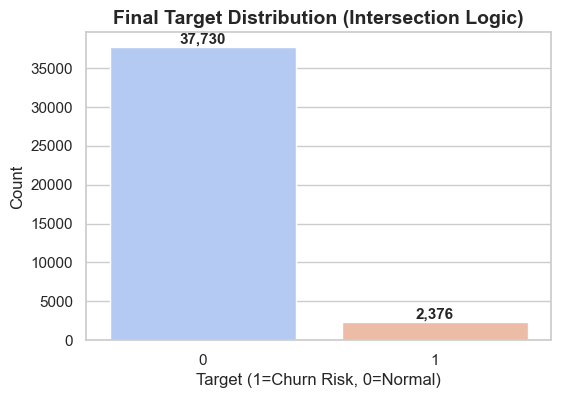

In [13]:
# =============================================================================
# [Logic Update] 교집합 조건(AND)을 적용한 정밀 타겟 생성
# =============================================================================

# 1. 조건 정의
# (조건 A) 기울기 3종(소비, 잔액, 건수)이 모두 0 이하인 경우 (df_all_le0 개념)
cond_slopes_decrease = (
    (df['Slope_Spend'] <= 0) & 
    (df['Slope_Balance'] <= 0) & 
    (df['Slope_Count'] <= 0)
)

# (조건 B) 4대 위험 징후 중 2개 이상 감지된 경우
cond_high_risk = (df['Risk_Count'] >= 2)

# 2. Target 생성 (교집합 적용)
# - 두 조건(A & B)을 모두 만족해야 이탈 위험군(1)
# - 하나라도 만족하지 않으면 일반군(0)
df['Target'] = np.where(cond_slopes_decrease & cond_high_risk, 1, 0)

# -----------------------------------------------------------------------------
# [검증] 결과 확인
# -----------------------------------------------------------------------------
print("✅ 교집합(AND) 조건이 적용된 Target 생성이 완료되었습니다!")
print(f"전체 고객 수: {len(df):,}명")

# 분포 확인
target_counts = df['Target'].value_counts().sort_index()
print("\n[최종 Target 분포]")
print(f"- 이탈 위험군 (Target=1): {target_counts.get(1, 0):,}명 ({target_counts.get(1, 0)/len(df)*100:.1f}%)")
print(f"- 일반군      (Target=2): {target_counts.get(0, 0):,}명 ({target_counts.get(0, 0)/len(df)*100:.1f}%)")
print(f"  └─ (참고) 조건A(기울기감소) 만족: {cond_slopes_decrease.sum():,}명")
print(f"  └─ (참고) 조건B(Risk>=2) 만족: {cond_high_risk.sum():,}명")

# 교차 검증 (Crosstab)
print("\n[조건별 데이터 매트릭스]")
print(pd.crosstab(cond_slopes_decrease, cond_high_risk, rownames=['기울기감소(A)'], colnames=['Risk>=2(B)'], margins=True))

# 샘플 데이터 확인 (Target=1인 경우만)
print("\n[이탈 위험군(Target=1) 샘플 데이터]")
print(df[df['Target']==1][['발급회원번호', 'Slope_Spend', 'Slope_Balance', 'Slope_Count', 'Risk_Count', 'Target']].head(5))

# =============================================================================
# [시각화] 최종 Target 분포 시각화
# =============================================================================
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
ax = sns.countplot(data=df, x='Target', palette='coolwarm')
plt.title('Final Target Distribution (Intersection Logic)', fontsize=14, fontweight='bold')
plt.xlabel('Target (1=Churn Risk, 0=Normal)')
plt.ylabel('Count')

# 막대 위에 숫자 표시
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}', (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.show()

In [14]:
df['Target'].value_counts(normalize=True)

Target
0    0.940757
1    0.059243
Name: proportion, dtype: float64

In [6]:
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

### 타겟컬럼_원본컬럼 머지

In [16]:
df_1 = pd.read_csv(file_path)

C:\Users\johnh\AppData\Local\Temp\ipykernel_10364\3076235782.py:1: DtypeWarning: Columns (254) have mixed types. Specify dtype option on import or set low_memory=False.
  df_1 = pd.read_csv(file_path)


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40106 entries, 0 to 40105
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   발급회원번호               40106 non-null  object 
 1   Score_BadDebt        40106 non-null  float64
 2   Score_Delinq         40106 non-null  float64
 3   Score_Activity       40106 non-null  float64
 4   Score_Asset          40106 non-null  float64
 5   Score_Status_Total   40106 non-null  float64
 6   Slope_Spend          40106 non-null  float64
 7   Slope_Balance        40106 non-null  float64
 8   Slope_Count          40106 non-null  float64
 9   Norm_Slope_Spend     40106 non-null  float64
 10  Norm_Slope_Balance   40106 non-null  float64
 11  Norm_Slope_Count     40106 non-null  float64
 12  Score_Slope_Total    40106 non-null  float64
 13  Final_Total_Score    40106 non-null  float64
 14  Cond1_Has_BadDebt    40106 non-null  bool   
 15  Cond2_Has_Delinq     40106 non-null 

In [18]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240636 entries, 0 to 240635
Columns: 822 entries, 기준년월 to 최종카드발급경과월
dtypes: float64(62), int64(728), object(32)
memory usage: 1.5+ GB


In [19]:
key_cols = ['발급회원번호']
df_2 = pd.merge(df,df_1, on=key_cols, how='inner')

In [20]:
df_2[['발급회원번호','Target']]

,발급회원번호,Target
0,SYN_1000048,0
1,SYN_1000048,0
2,SYN_1000048,0
3,SYN_1000048,0
4,SYN_1000048,0
...,...,...
240631,SYN_999995,0
240632,SYN_999995,0
240633,SYN_999995,0
240634,SYN_999995,0


# 변수중요도 확인 -> Feature Importance by LightGBM

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

df = df_2

🧹 데이터 정리 중...
   - 초기 변수 개수: 800 개
   - 무의미한(값 고정) 컬럼 제거 후: 708 개
   - (제거된 컬럼 수: 92 개)

🚀 LightGBM 모델 학습 중... (RF보다 훨씬 빠릅니다)


C:\Users\johnh\AppData\Local\Temp\ipykernel_10364\2027049700.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_20_features, x='Importance', y='Feature', palette='magma')


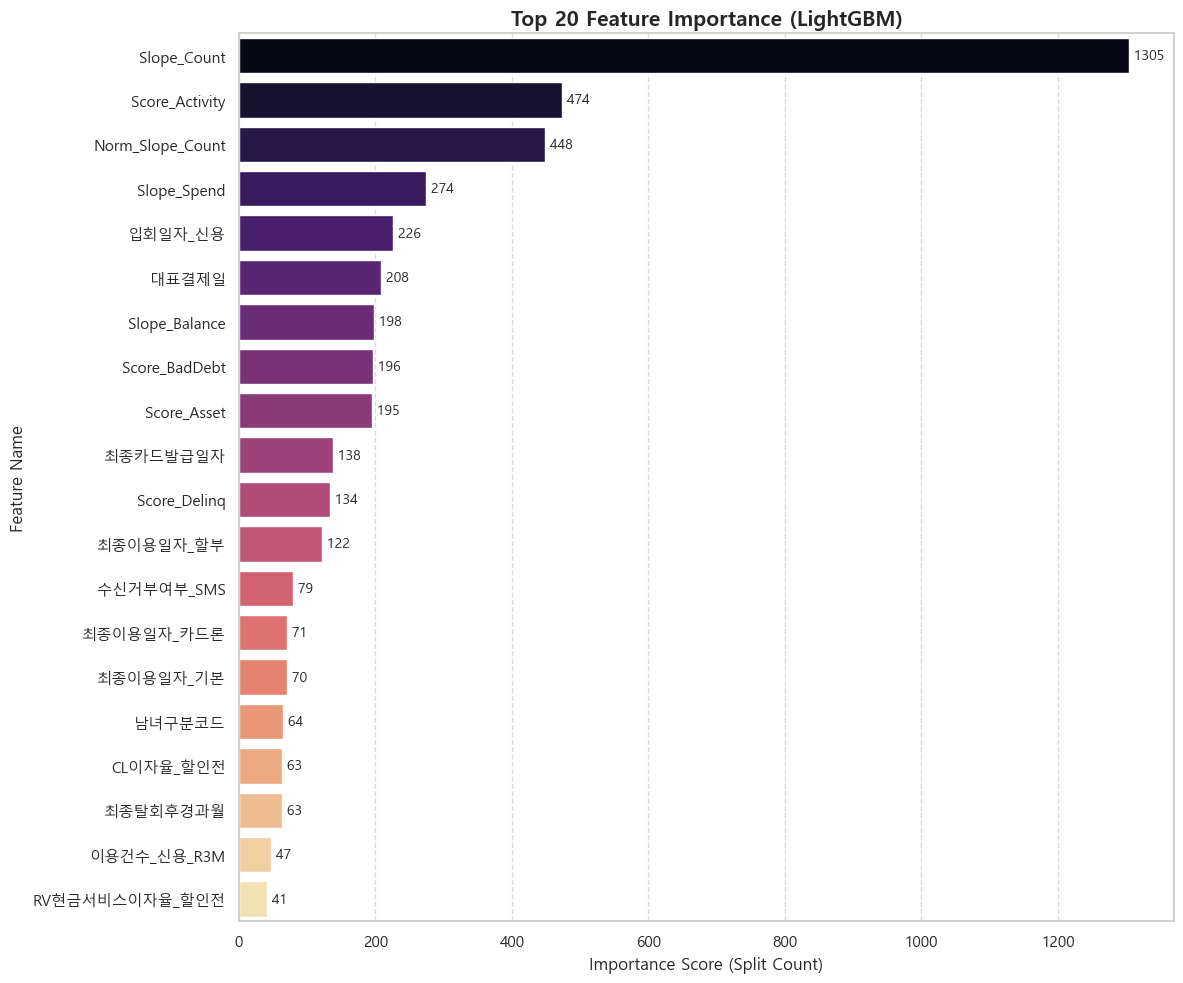

📊 분석 완료.
   - 최종 사용된 변수: 708 개
   - 상위 변수들이 이탈을 구분하는 데 가장 많이 사용되었습니다.


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
import lightgbm as lgb  # Random Forest 대신 사용 (훨씬 빠름)


# 
# =============================================================================
# [Step 1] 데이터 다이어트 (전처리)
# =============================================================================
print("🧹 데이터 정리 중...")

# 1. 분석 제외 대상 컬럼 설정
# (식별자, 타겟, 이미 생성한 파생변수 결과값 등은 제외)
exclude_cols = ['발급회원번호', 'Target', 'Churn_Segment', 'Risk_Count',
                'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero',
                'Score_Status_Total', 'Score_Slope_Total', 'Final_Total_Score']

# 2. 수치형 데이터만 우선 선택 (속도 및 에러 방지)
# 5000개 중 문자열(Object)이 섞여 있으면 인코딩하느라 시간이 오래 걸리므로, 일단 수치형 위주로 봅니다.
df_numeric = df.select_dtypes(include=[np.number])
X = df_numeric.drop(columns=[c for c in exclude_cols if c in df_numeric.columns], errors='ignore')
y = df['Target']

print(f"   - 초기 변수 개수: {X.shape[1]:,} 개")

# 무한대(inf)와 결측치(NaN)를 모두 0으로 안전하게 대체합니다.
X = X.replace([np.inf, -np.inf], 0)
X = X.fillna(0)

# 3. [핵심] 분산이 0인(모든 값이 똑같은) 컬럼 제거
# 예: 모든 고객의 '가입비'가 0원이라면, 이 변수는 분석 가치가 없습니다.
selector = VarianceThreshold(threshold=0)
selector.fit(X)

# 선택된 컬럼만 남기기
X_reduced = X.loc[:, selector.get_support()]

print(f"   - 무의미한(값 고정) 컬럼 제거 후: {X_reduced.shape[1]:,} 개")
print(f"   - (제거된 컬럼 수: {X.shape[1] - X_reduced.shape[1]:,} 개)")

# =============================================================================
# [Step 2] LightGBM으로 고속 학습
# =============================================================================
print("\n🚀 LightGBM 모델 학습 중... (RF보다 훨씬 빠릅니다)")

# LGBM 설정: 속도 위주 세팅
lgbm_model = lgb.LGBMClassifier(
    n_estimators=200,      # 나무의 개수
    learning_rate=0.1,     # 학습률
    num_leaves=31,         # 잎의 개수 (복잡도 제어)
    n_jobs=-1,             # 모든 CPU 코어 사용
    random_state=42,
    verbose=-1             # 경고 메시지 숨김
)

lgbm_model.fit(X_reduced, y)

# =============================================================================
# [Step 3] 중요도 시각화
# =============================================================================

# 중요도 추출
feature_imp = pd.DataFrame({
    'Feature': X_reduced.columns,
    'Importance': lgbm_model.feature_importances_
})

# 중요도 0인 변수 제외하고, 상위 20개 정렬
top_20_features = feature_imp[feature_imp['Importance'] > 0].sort_values(by='Importance', ascending=False).head(20)

plt.figure(figsize=(12, 10))
sns.barplot(data=top_20_features, x='Importance', y='Feature', palette='magma')

plt.title('Top 20 Feature Importance (LightGBM)', fontsize=15, fontweight='bold')
plt.xlabel('Importance Score (Split Count)', fontsize=12)
plt.ylabel('Feature Name', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# 수치 텍스트 표시
for i, v in enumerate(top_20_features['Importance']):
    plt.text(v, i, f' {int(v)}', va='center', fontsize=10)

plt.tight_layout()
# plt.savefig('Feature_Importance_LightGBM.png', dpi=300)
plt.show()

print("📊 분석 완료.")
print(f"   - 최종 사용된 변수: {X_reduced.shape[1]:,} 개")
print("   - 상위 변수들이 이탈을 구분하는 데 가장 많이 사용되었습니다.")

In [23]:
feature_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 708 entries, 0 to 707
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Feature     708 non-null    object
 1   Importance  708 non-null    int32 
dtypes: int32(1), object(1)
memory usage: 8.4+ KB


In [24]:
feature_imp['Importance'] = feature_imp['Importance'].sort_values(ascending=False, ignore_index=True)

In [25]:
feature_imp

,Feature,Importance
0,Score_BadDebt,1305
1,Score_Delinq,474
2,Score_Activity,448
3,Score_Asset,274
4,Slope_Spend,226
...,...,...
703,제휴연회비_B0M,0
704,청구금액_기본연회비_B0M,0
705,청구금액_제휴연회비_B0M,0
706,카드신청건수,0


In [26]:
df_2['Target'].value_counts(normalize=True)

Target
0    0.940757
1    0.059243
Name: proportion, dtype: float64

## Feature Importance 를 이용해 컬럼 추출

In [27]:
# =============================================================================
# [Step 6] Feature Selection (Top 100) - 메모리 반환 버전 (저장 X)
# =============================================================================

def select_top100_features(source_df, importance_df):
    print(f"[Process] Top 100 Feature 추출 시작 (메모리 내 처리)...")
    
    # ---------------------------------------------------------
    # 1. Feature Importance 필터링
    # ---------------------------------------------------------
    # (안전장치) 내림차순 정렬
    df_imp_sorted = importance_df.sort_values(by='Importance', ascending=False)
    
    # 조건: Importance > 0
    df_imp_active = df_imp_sorted[df_imp_sorted['Importance'] > 0]
    
    # 상위 100개 추출
    top_features = df_imp_active.head(100)['Feature'].tolist()
    
    print(f"  - 중요도 > 0 인 컬럼 수: {len(df_imp_active)}개")
    print(f"  - 최종 선정된 Feature 수 (Top 100): {len(top_features)}개")
    
    if len(top_features) == 0:
        print("  [!] 경고: 조건에 맞는 Feature가 없습니다.")
        return None

    # ---------------------------------------------------------
    # 2. 원본 데이터(source_df)에서 컬럼 선택
    # ---------------------------------------------------------
    # 필수 컬럼 정의 (Target, ID 등 분석에 꼭 필요한 컬럼)
    essential_cols = ['발급회원번호', 'Target']
    
    # 원본 데이터에 실제 존재하는 컬럼인지 확인 (KeyError 방지)
    valid_features = [col for col in top_features if col in source_df.columns]
    
    # 제외된 컬럼 확인
    missing_cols = set(top_features) - set(valid_features)
    if missing_cols:
        print(f"  [!] 주의: 원본 데이터에 없는 컬럼 {len(missing_cols)}개가 제외되었습니다.")
    
    # 최종 선택 컬럼 리스트 생성 (순서: 필수 -> 중요도순)
    final_cols = essential_cols + valid_features
    
    # 중복 제거 (필수 컬럼이 중요도 리스트에도 있을 경우 대비)
    final_cols = list(dict.fromkeys(final_cols))
    
    # ---------------------------------------------------------
    # 3. 데이터 슬라이싱 및 반환
    # ---------------------------------------------------------
    try:
        df_result = source_df[final_cols].copy()
        print(f"  ✅ 데이터 추출 완료. Shape: {df_result.shape}")
        return df_result
        
    except Exception as e:
        print(f"  [!] 추출 중 오류 발생: {e}")
        return None

# =============================================================================
# [실행]
# =============================================================================

# (안전장치) df_2 확인 (앞선 단계에서 Target이 병합된 데이터프레임)
if 'df_2' not in locals():
    if 'df' in locals():
        print("⚠ 'df_2'가 없어 현재 메모리의 'df'를 사용합니다.")
        df_2 = df.copy()
    else:
        print("⛔ 오류: 데이터프레임('df' 또는 'df_2')이 정의되지 않았습니다.")

# 함수 실행 (결과를 df_final 변수에 저장)
if 'feature_imp' in locals() and 'df_2' in locals():
    # 파일로 저장하지 않고, 변수(df_final)로 받아서 바로 사용
    df_final = select_top100_features(df_2, feature_imp)
    
    # 결과 확인
    if df_final is not None:
        print("\n[Result Sample]")
        print(df_final.head())
else:
    print("⛔ 'feature_imp' 변수(중요도 데이터프레임)가 정의되지 않았습니다.")

[Process] Top 100 Feature 추출 시작 (메모리 내 처리)...
  - 중요도 > 0 인 컬럼 수: 225개
  - 최종 선정된 Feature 수 (Top 100): 100개
  ✅ 데이터 추출 완료. Shape: (240636, 102)

[Result Sample]
        발급회원번호  Target  Score_BadDebt  Score_Delinq  Score_Activity  \
0  SYN_1000048       0            0.0           0.0       12.021858   
1  SYN_1000048       0            0.0           0.0       12.021858   
2  SYN_1000048       0            0.0           0.0       12.021858   
3  SYN_1000048       0            0.0           0.0       12.021858   
4  SYN_1000048       0            0.0           0.0       12.021858   

   Score_Asset   Slope_Spend  Slope_Balance  Slope_Count  Norm_Slope_Spend  \
0      9.32688  17871.228571        56172.4     1.942857               0.0   
1      9.32688  17871.228571        56172.4     1.942857               0.0   
2      9.32688  17871.228571        56172.4     1.942857               0.0   
3      9.32688  17871.228571        56172.4     1.942857               0.0   
4      9.32688  17871.

In [28]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240636 entries, 0 to 240635
Columns: 102 entries, 발급회원번호 to 이용건수_부분무이자_R12M
dtypes: float64(57), int64(44), object(1)
memory usage: 187.3+ MB


## 모델 돌리기 - lightGBM

In [29]:
import pandas as pd

# 1. 모든 열(Column)을 다 보여주기 (생략 ... 방지)
pd.set_option('display.max_columns', None)

# 2. 모든 행(Row)을 다 보여주기 (데이터가 너무 많으면 브라우저가 느려질 수 있으니 주의)
# pd.set_option('display.max_rows', None)  # 필요할 때만 주석 해제해서 사용하세요

# 3. 컬럼 내의 텍스트가 길어도 자르지 않고 다 보여주기
pd.set_option('display.max_colwidth', None)

# 4. 가로 폭을 넓게 설정 (줄바꿈 방지)
pd.set_option('display.width', 1000)

print("✅ 출력 제한 옵션이 해제되었습니다.")

✅ 출력 제한 옵션이 해제되었습니다.



==================== [GENERAL] Training Start (Balanced) ====================
 - 학습 Feature 수: 90개
 - 학습 데이터 샘플 수: 240636개
✅ 학습 완료 (소요시간: 4.64초)

📊 [GENERAL] Model Performance Report
 - Accuracy  : 0.8562
 - F1 Score  : 0.8888
 - ROC-AUC   : 0.9416
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.85      0.92     45277
           1       0.28      0.91      0.43      2851

    accuracy                           0.86     48128
   macro avg       0.64      0.88      0.67     48128
weighted avg       0.95      0.86      0.89     48128



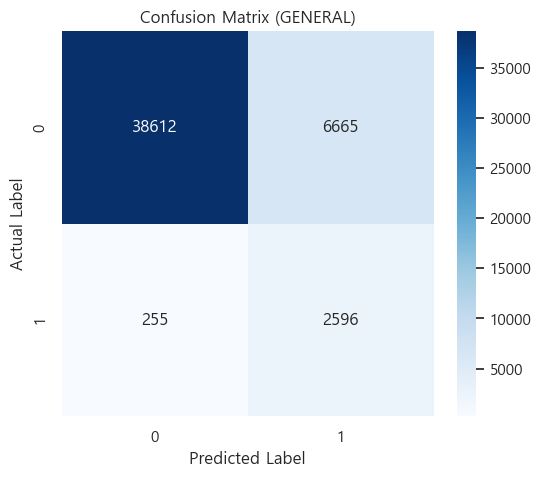

<Figure size 1000x800 with 0 Axes>

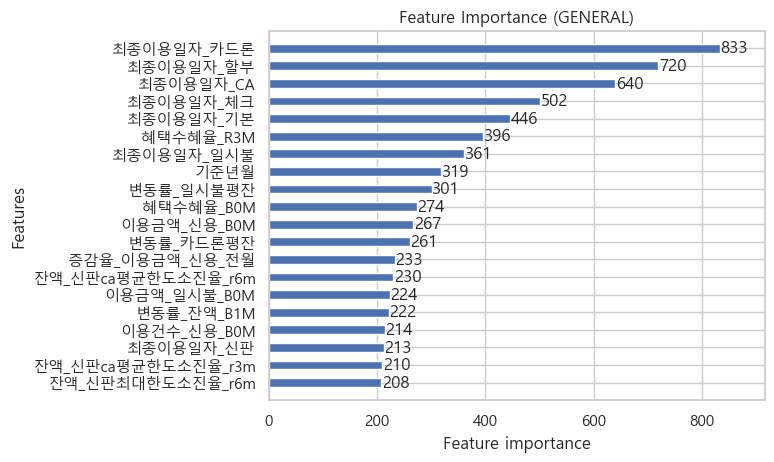

In [30]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

# =============================================================================
# [Step 7] LightGBM 모델 학습 (General Only)
# =============================================================================

def train_eval_lgbm_general(input_data, group_name='GENERAL', device_type='cpu'):
    print(f"\n{'='*20} [{group_name}] Training Start (Balanced) {'='*20}")
    
    # 1. 데이터 준비
    if input_data is None:
        print("❌ 입력 데이터가 없습니다 (None). 앞 단계의 추출 결과를 확인해주세요.")
        return None, None
        
    df_train = input_data.copy()

    # 2. Leakage 변수 제거 (타겟 유출 방지)
    # Target과 발급회원번호는 학습에 직접 쓰지 않으므로 분리
    leakage_cols = [
        'Target', '발급회원번호', 'Unnamed: 0',
        # 아래 변수들은 Feature Importance 단계에서 이미 걸러졌을 수 있으나 안전장치로 포함
        'Slope_Spend', 'Slope_Balance', 'Slope_Count', 
        'Norm_Slope_Spend', 'Norm_Slope_Balance', 'Norm_Slope_Count',
        'Score_BadDebt', 'Score_Delinq', 'Score_Activity', 'Score_Asset',
        'Score_Status_Total', 'Score_Slope_Total', 'Final_Total_Score',
        'Risk_Count', 'Churn_Segment',
        'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero'
    ]
    
    # 실제 학습에 사용할 Feature(X)와 Target(y) 분리
    # Target은 반드시 존재해야 함
    if 'Target' not in df_train.columns:
        print("❌ 'Target' 컬럼이 없습니다.")
        return None, None

    y = df_train['Target']
    
    # Leakage 컬럼 제외 및 수치형 데이터만 선택
    cols_to_drop = [c for c in leakage_cols if c in df_train.columns]
    X = df_train.drop(columns=cols_to_drop)
    X = X.select_dtypes(include=['number']) 
    
    print(f" - 학습 Feature 수: {X.shape[1]}개")
    print(f" - 학습 데이터 샘플 수: {X.shape[0]}개")
    
    # 3. Train / Test Split
    # stratify=y를 통해 이탈/비이탈 비율을 유지하며 분할
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # 4. LightGBM 파라미터 설정
    params = {
        'n_estimators': 400,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'max_depth': -1,
        'random_state': 42,
        'n_jobs': -1,
        'device': device_type,
        'verbose': -1,
        'class_weight': 'balanced' # [핵심] 불균형 데이터 자동 보정
    }
    
    # GPU 설정 (필요시 활성화)
    if device_type == 'gpu':
        params['gpu_platform_id'] = 0
        params['gpu_device_id'] = 0

    model = lgb.LGBMClassifier(**params)
    
    # 5. 모델 학습
    start_time = time.time()
    try:
        model.fit(X_train, y_train)
    except Exception as e:
        print(f"⚠️ 학습 중 에러 발생 ({e}). CPU 모드로 전환하여 재시도합니다.")
        params['device'] = 'cpu'
        if 'gpu_platform_id' in params: del params['gpu_platform_id']
        if 'gpu_device_id' in params: del params['gpu_device_id']
        
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train)
            
    elapsed = time.time() - start_time
    print(f"✅ 학습 완료 (소요시간: {elapsed:.2f}초)")

    # 6. 성능 평가
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted') # 다중 클래스일 경우 weighted 권장 (2진분류도 호환)
    # AUC는 2진 분류일 때만 계산 (Target 1, 2인 경우 0, 1로 매핑 필요할 수 있음)
    try:
        # Target이 1, 2로 되어있다면 2를 0으로 인식하게 하거나 pos_label 지정 필요
        # 여기서는 모델이 알아서 클래스를 인식하므로 그대로 진행 시도
        auc = roc_auc_score(y_test, y_prob)
    except:
        auc = 0.0 # 에러 시 0 처리

    print(f"\n📊 [{group_name}] Model Performance Report")
    print(f" - Accuracy  : {acc:.4f}")
    print(f" - F1 Score  : {f1:.4f}")
    print(f" - ROC-AUC   : {auc:.4f}")
    print("-" * 50)
    print(classification_report(y_test, y_pred))

    # Confusion Matrix 시각화
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix ({group_name})')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Feature Importance 시각화 (Top 20)
    plt.figure(figsize=(10, 8))
    lgb.plot_importance(model, max_num_features=20, height=0.5, title=f'Feature Importance ({group_name})')
    plt.show()

    return model, (acc, f1, auc)

# =============================================================================
# [실행] General 모델 학습
# =============================================================================

# df_final: 앞선 [Step 6]에서 Top 100 Feature로 추출된 데이터프레임
if 'df_final' in locals() and df_final is not None:
    model_gen, res_gen = train_eval_lgbm_general(
        input_data=df_final, 
        group_name='GENERAL', 
        device_type='cpu' # GPU 사용 시 'gpu'로 변경
    )
else:
    print("⛔ 'df_final' 데이터가 준비되지 않았습니다. 앞선 코드를 먼저 실행해주세요.")

## 모델 파라미터 수정

📊 [Feature Importance Top 10]
      Feature  Importance
0  최종이용일자_카드론         833
1   최종이용일자_할부         720
2   최종이용일자_CA         640
3   최종이용일자_체크         502
4   최종이용일자_기본         446
5   혜택수혜율_R3M         396
6  최종이용일자_일시불         361
7        기준년월         319
8   변동률_일시불평잔         301
9   혜택수혜율_B0M         274
----------------------------------------
🚨 [Leakage 진단]
   - 1위 변수: 최종이용일자_카드론 (833)
   - 2위 변수: 최종이용일자_할부 (720)
   - 격차 비율: 1.16배
   ✅ 양호: 특정 변수의 독점 현상은 보이지 않습니다.


C:\Users\johnh\AppData\Local\Temp\ipykernel_10364\2147272484.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=imp_df.head(20), x='Importance', y='Feature', palette='viridis')


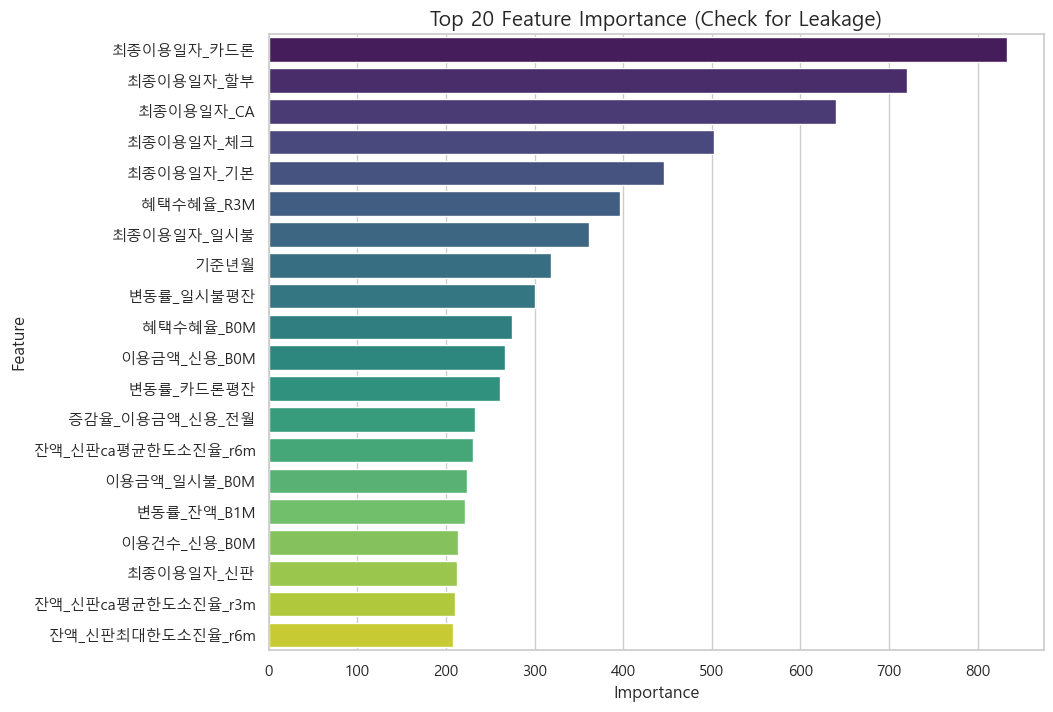

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# =============================================================================
# [검증] Feature Importance 정밀 분석 (Leakage 탐지용)
# =============================================================================

def check_feature_leakage(model, feature_names):
    # 1. 중요도 추출 (Split 기준: 변수가 모델 분기에 사용된 횟수)
    imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': model.feature_importances_
    })
    
    # 2. 내림차순 정렬
    imp_df = imp_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
    
    # 3. [핵심] 1위와 2위의 격차 계산
    top1_score = imp_df.loc[0, 'Importance']
    top2_score = imp_df.loc[1, 'Importance']
    ratio = top1_score / top2_score if top2_score > 0 else 0
    
    print(f"📊 [Feature Importance Top 10]")
    print(imp_df.head(10))
    print("-" * 40)
    print(f"🚨 [Leakage 진단]")
    print(f"   - 1위 변수: {imp_df.loc[0, 'Feature']} ({top1_score})")
    print(f"   - 2위 변수: {imp_df.loc[1, 'Feature']} ({top2_score})")
    print(f"   - 격차 비율: {ratio:.2f}배")
    
    if ratio >= 2.0:
        print("   ⚠️ 경고: 1위 변수의 영향력이 2위보다 2배 이상 큽니다. Leakage 가능성을 의심해 보세요.")
    else:
        print("   ✅ 양호: 특정 변수의 독점 현상은 보이지 않습니다.")
        
    # 4. 시각화
    plt.figure(figsize=(10, 8))
    sns.barplot(data=imp_df.head(20), x='Importance', y='Feature', palette='viridis')
    plt.title('Top 20 Feature Importance (Check for Leakage)', fontsize=15)
    plt.show()
    
    return imp_df

# 실행 (model_gen이 메모리에 있어야 함)
if 'model_gen' in locals():
    # 모델에서 사용된 Feature 이름 가져오기
    feature_names = model_gen.feature_name_
    df_importance_check = check_feature_leakage(model_gen, feature_names)
else:
    print("⛔ 'model_gen' 모델이 정의되지 않았습니다. 앞선 모델 학습 코드를 먼저 실행해주세요.")

#### 모델 재학습 - 최종 이용 일자 관련 컬럼 제거


==================== [GENERAL] Re-Training (Leakage Removed) ====================
 - 제거된 Leakage 변수: 20개
 - 최종 학습 Feature 수: 82개
✅ 재학습 완료 (소요시간: 4.23초)

📊 [GENERAL] New Model Performance
 - Accuracy  : 0.8325
 - F1 Score  : 0.8724
 - ROC-AUC   : 0.9226
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.83      0.90     45277
           1       0.25      0.89      0.39      2851

    accuracy                           0.83     48128
   macro avg       0.62      0.86      0.64     48128
weighted avg       0.95      0.83      0.87     48128



<Figure size 1000x800 with 0 Axes>

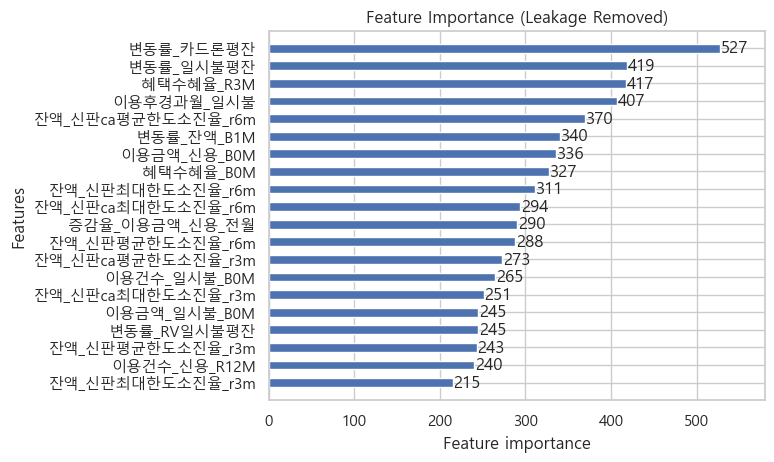

In [32]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

# =============================================================================
# [Step 7] LightGBM 모델 재학습 (Leakage 변수 추가 제거)
# =============================================================================

def train_eval_lgbm_general_v2(input_data, group_name='GENERAL', device_type='cpu'):
    print(f"\n{'='*20} [{group_name}] Re-Training (Leakage Removed) {'='*20}")
    
    if input_data is None:
        print("❌ 입력 데이터가 없습니다.")
        return None, None
        
    df_train = input_data.copy()

    # -------------------------------------------------------------------------
    # [수정] 제거할 변수 목록 업데이트 (최종이용일자, 기준년월 포함)
    # -------------------------------------------------------------------------
    leakage_cols = [
        'Target', '발급회원번호', 'Unnamed: 0', '기준년월', # 기준년월도 제거 권장
        
        # [NEW] Leakage로 판명된 날짜 관련 변수 제거
        '최종이용일자_카드론', '최종이용일자_할부', '최종이용일자_CA', 
        '최종이용일자_체크', '최종이용일자_기본', '최종이용일자_일시불',
        '최종이용일자_신판', # 혹시 있다면 같이 제거
        
        # 기존 제외 변수들
        'Slope_Spend', 'Slope_Balance', 'Slope_Count', 
        'Norm_Slope_Spend', 'Norm_Slope_Balance', 'Norm_Slope_Count',
        'Score_BadDebt', 'Score_Delinq', 'Score_Activity', 'Score_Asset',
        'Score_Status_Total', 'Score_Slope_Total', 'Final_Total_Score',
        'Risk_Count', 'Churn_Segment',
        'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero'
    ]
    
    # 실제 존재하는 컬럼만 골라서 제거
    cols_to_drop = [c for c in leakage_cols if c in df_train.columns]
    
    # -------------------------------------------------------------------------
    
    y = df_train['Target']
    X = df_train.drop(columns=cols_to_drop)
    X = X.select_dtypes(include=['number']) 
    
    print(f" - 제거된 Leakage 변수: {len(cols_to_drop)}개")
    print(f" - 최종 학습 Feature 수: {X.shape[1]}개")
    
    # Train / Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # LightGBM 파라미터
    params = {
        'n_estimators': 400,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'max_depth': -1,
        'random_state': 42,
        'n_jobs': -1,
        'device': device_type,
        'verbose': -1,
        'class_weight': 'balanced' 
    }
    
    if device_type == 'gpu':
        params['gpu_platform_id'] = 0
        params['gpu_device_id'] = 0

    model = lgb.LGBMClassifier(**params)
    
    # 학습
    start_time = time.time()
    model.fit(X_train, y_train)
    elapsed = time.time() - start_time
    print(f"✅ 재학습 완료 (소요시간: {elapsed:.2f}초)")

    # 평가
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    try:
        auc = roc_auc_score(y_test, y_prob)
    except:
        auc = 0.0

    print(f"\n📊 [{group_name}] New Model Performance")
    print(f" - Accuracy  : {acc:.4f}")
    print(f" - F1 Score  : {f1:.4f}")
    print(f" - ROC-AUC   : {auc:.4f}")
    print("-" * 50)
    print(classification_report(y_test, y_pred))

    # Feature Importance 재확인
    plt.figure(figsize=(10, 8))
    lgb.plot_importance(model, max_num_features=20, height=0.5, title=f'Feature Importance (Leakage Removed)')
    plt.show()

    return model, (acc, f1, auc)

# 실행
if 'df_final' in locals() and df_final is not None:
    model_gen_v2, res_gen_v2 = train_eval_lgbm_general_v2(
        input_data=df_final, 
        group_name='GENERAL', 
        device_type='cpu'
    )

#### Optuna 를 활용한 최적의 파라미터 찾기

c:\Users\johnh\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-12-31 13:23:58,593] A new study created in memory with name: no-name-4f52fa99-5b87-4d5b-94ef-e475cf708f10


==================== [Optuna] Hyperparameter Tuning Start ====================
 - 목표: F1 Score (Class 1) 최대화
 - 탐색 횟수: 20회 (시간 관계상 20회로 설정, 필요시 n_trials 증가 가능)


[I 2025-12-31 13:24:03,580] Trial 0 finished with value: 0.412712233347845 and parameters: {'n_estimators': 350, 'learning_rate': 0.09556428757689246, 'num_leaves': 50, 'max_depth': 11, 'min_child_samples': 32, 'reg_alpha': 1.5599452033620265, 'reg_lambda': 0.5808361216819946, 'scale_pos_weight': 13.126466040849092}. Best is trial 0 with value: 0.412712233347845.
[I 2025-12-31 13:24:08,227] Trial 1 finished with value: 0.4469975127324411 and parameters: {'n_estimators': 441, 'learning_rate': 0.0737265320016441, 'num_leaves': 20, 'max_depth': 15, 'min_child_samples': 87, 'reg_alpha': 2.1233911067827616, 'reg_lambda': 1.8182496720710062, 'scale_pos_weight': 3.5676631379480734}. Best is trial 1 with value: 0.4469975127324411.
[I 2025-12-31 13:24:20,241] Trial 2 finished with value: 0.4404202101050525 and parameters: {'n_estimators': 322, 'learning_rate': 0.05722807884690141, 'num_leaves': 37, 'max_depth': 8, 'min_child_samples': 69, 'reg_alpha': 1.3949386065204183, 'reg_lambda': 2.9214464


✅ 최적화 완료!
 - Best F1 Score: 0.4489
 - Best Params: {'n_estimators': 481, 'learning_rate': 0.07044153842586906, 'num_leaves': 53, 'max_depth': 12, 'min_child_samples': 61, 'reg_alpha': 2.77977230544977, 'reg_lambda': 1.269848440010871, 'scale_pos_weight': 5.778309768000859}

==================== [Optuna Best Model] Final Training ====================

📊 [Final Optimized Model] Performance Report
 - Accuracy  : 0.8945
 - F1 Score  : 0.9125
 - ROC-AUC   : 0.9257
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.98      0.91      0.94     45277
           1       0.33      0.73      0.45      2851

    accuracy                           0.89     48128
   macro avg       0.65      0.82      0.70     48128
weighted avg       0.94      0.89      0.91     48128



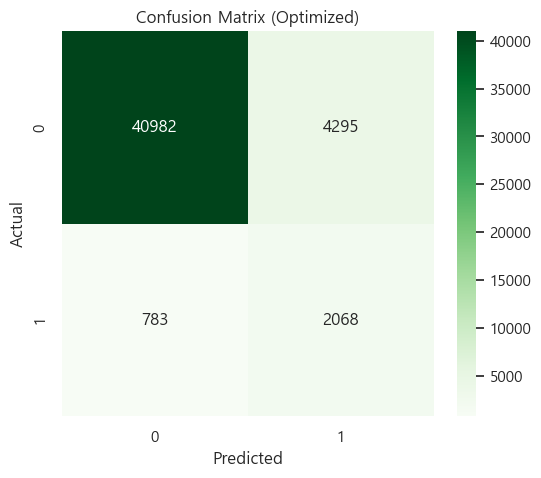

<Figure size 1000x800 with 0 Axes>

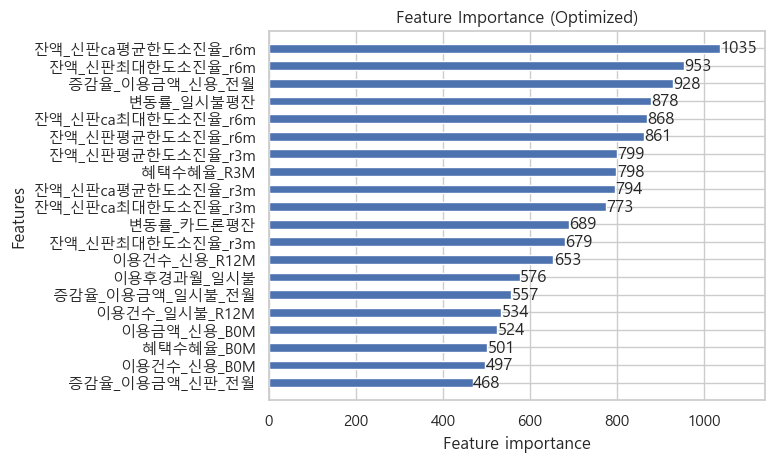

In [33]:
import optuna
from optuna.samplers import TPESampler
import lightgbm as lgb
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

# =============================================================================
# [Step 8] Optuna를 활용한 하이퍼파라미터 최적화 (Auto-Tuning)
# =============================================================================

def objective(trial):
    # 1. 데이터 준비 (Leakage 제거된 df_final 사용)
    # (Global 변수 df_final을 참조합니다)
    data = df_final.copy()
    
    # Leakage 컬럼 제거 (앞선 Step 7과 동일하게 적용)
    leakage_cols = [
        'Target', '발급회원번호', 'Unnamed: 0', '기준년월',
        '최종이용일자_카드론', '최종이용일자_할부', '최종이용일자_CA', 
        '최종이용일자_체크', '최종이용일자_기본', '최종이용일자_일시불', '최종이용일자_신판',
        'Slope_Spend', 'Slope_Balance', 'Slope_Count', 
        'Norm_Slope_Spend', 'Norm_Slope_Balance', 'Norm_Slope_Count',
        'Score_BadDebt', 'Score_Delinq', 'Score_Activity', 'Score_Asset',
        'Score_Status_Total', 'Score_Slope_Total', 'Final_Total_Score',
        'Risk_Count', 'Churn_Segment',
        'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero'
    ]
    cols_to_drop = [c for c in leakage_cols if c in data.columns]
    
    X = data.drop(columns=cols_to_drop).select_dtypes(include=['number'])
    y = data['Target']
    
    # Train / Valid Split (검증용 데이터 분리)
    X_train, X_valid, y_train, y_valid = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # 2. 튜닝할 파라미터 탐색 범위 설정 (Search Space)
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 600),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 60),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        
        # [핵심] class_weight 비율 조절 (1 ~ 15)
        # 1에 가까울수록 일반 학습, 15에 가까울수록 balanced와 유사
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 15.0),
        
        'random_state': 42,
        'n_jobs': -1,
        'verbose': -1,
        'device': 'cpu' # GPU 사용시 'gpu'로 변경
    }
    
    # 3. 모델 학습
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train, y_train)
    
    # 4. 평가 지표 (F1 Score Maximization)
    # Precision과 Recall의 조화평균인 F1 Score를 최대화하는 방향으로 최적화
    y_pred = model.predict(X_valid)
    
    # Target이 1인 클래스(이탈자)에 대한 F1 Score 반환
    # (average='binary'는 Target 0, 1 중 1을 Positive로 간주)
    score = f1_score(y_valid, y_pred, pos_label=1)
    
    return score

# -----------------------------------------------------------------------------
# [실행] 최적화 프로세스 시작
# -----------------------------------------------------------------------------
print(f"{'='*20} [Optuna] Hyperparameter Tuning Start {'='*20}")
print(" - 목표: F1 Score (Class 1) 최대화")
print(" - 탐색 횟수: 20회 (시간 관계상 20회로 설정, 필요시 n_trials 증가 가능)")

# Study 생성 및 최적화 수행
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
study.optimize(objective, n_trials=20) # 20번 시도

# 결과 출력
print(f"\n✅ 최적화 완료!")
print(f" - Best F1 Score: {study.best_value:.4f}")
print(f" - Best Params: {study.best_params}")

# -----------------------------------------------------------------------------
# [최종] Best Parameter로 모델 재학습 및 상세 리포트
# -----------------------------------------------------------------------------
best_params = study.best_params
best_params['random_state'] = 42
best_params['n_jobs'] = -1
best_params['verbose'] = -1

print(f"\n{'='*20} [Optuna Best Model] Final Training {'='*20}")

# 데이터 준비 (재학습용)
data = df_final.copy()
leakage_cols = [
    'Target', '발급회원번호', 'Unnamed: 0', '기준년월',
    '최종이용일자_카드론', '최종이용일자_할부', '최종이용일자_CA', 
    '최종이용일자_체크', '최종이용일자_기본', '최종이용일자_일시불', '최종이용일자_신판',
    'Slope_Spend', 'Slope_Balance', 'Slope_Count', 
    'Norm_Slope_Spend', 'Norm_Slope_Balance', 'Norm_Slope_Count',
    'Score_BadDebt', 'Score_Delinq', 'Score_Activity', 'Score_Asset',
    'Score_Status_Total', 'Score_Slope_Total', 'Final_Total_Score',
    'Risk_Count', 'Churn_Segment',
    'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero'
]
cols_to_drop = [c for c in leakage_cols if c in data.columns]
X = data.drop(columns=cols_to_drop).select_dtypes(include=['number'])
y = data['Target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 최적 파라미터로 모델 생성
final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(X_train, y_train)

# 최종 평가
y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:, 1]

print(f"\n📊 [Final Optimized Model] Performance Report")
print(f" - Accuracy  : {accuracy_score(y_test, y_pred):.4f}")
print(f" - F1 Score  : {f1_score(y_test, y_pred, average='weighted'):.4f}")
print(f" - ROC-AUC   : {roc_auc_score(y_test, y_prob):.4f}")
print("-" * 50)
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix (Optimized)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Feature Importance
plt.figure(figsize=(10, 8))
lgb.plot_importance(final_model, max_num_features=20, height=0.5, title='Feature Importance (Optimized)')
plt.show()

#### Threshold(임계값) 찾기


📊 [Threshold Optimization Report]
 - 기본 설정 (0.50) F1 Score : 0.4489
 - 최적 설정 (0.5026) F1 Score : 0.4494 (▲ Improvement)


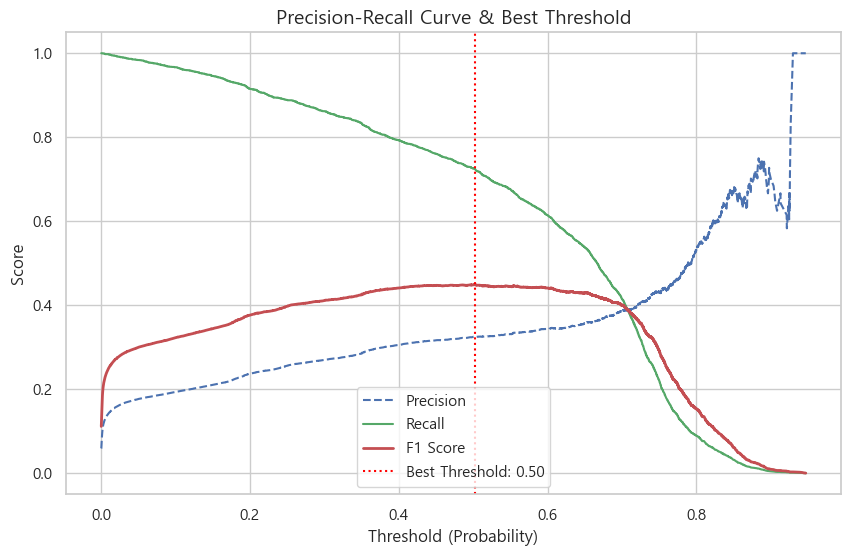


[0.5026 임계값 적용 시 성능]
              precision    recall  f1-score   support

           0       0.98      0.91      0.94     45277
           1       0.33      0.72      0.45      2851

    accuracy                           0.89     48128
   macro avg       0.65      0.82      0.70     48128
weighted avg       0.94      0.89      0.91     48128



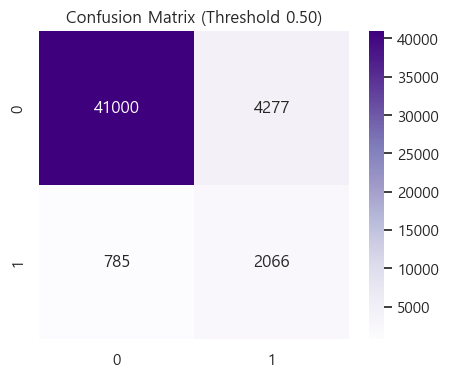

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score, confusion_matrix

# =============================================================================
# [Step 9] 최적의 결정 임계값(Threshold) 탐색
# =============================================================================

def find_optimal_threshold(model, X_test, y_test):
    # 1. 이탈 확률 예측 (Probability)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # 2. Precision-Recall Curve 계산
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)
    
    # 3. F1 Score 계산 (모든 임계값에 대해)
    # F1 = 2 * (Precision * Recall) / (Precision + Recall)
    # 분모가 0이 되는 경우를 대비해 안전장치 추가
    numerator = 2 * precisions * recalls
    denominator = precisions + recalls
    f1_scores = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0)
    
    # 4. 최대 F1 Score를 가지는 인덱스 찾기
    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    
    print(f"\n📊 [Threshold Optimization Report]")
    print(f" - 기본 설정 (0.50) F1 Score : {f1_score(y_test, (y_prob >= 0.5).astype(int)):.4f}")
    print(f" - 최적 설정 ({best_threshold:.4f}) F1 Score : {best_f1:.4f} (▲ Improvement)")
    
    # 5. 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.plot(thresholds, f1_scores[:-1], 'r-', label='F1 Score', linewidth=2)
    
    plt.axvline(best_threshold, color='red', linestyle=':', label=f'Best Threshold: {best_threshold:.2f}')
    plt.title('Precision-Recall Curve & Best Threshold', fontsize=14)
    plt.xlabel('Threshold (Probability)')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    
    return best_threshold

# [실행]
# final_model과 테스트 데이터가 메모리에 있어야 합니다.
if 'final_model' in locals():
    best_th = find_optimal_threshold(final_model, X_test, y_test)
    
    # [검증] 최적 임계값 적용 결과 확인
    print(f"\n[{best_th:.4f} 임계값 적용 시 성능]")
    y_pred_new = (final_model.predict_proba(X_test)[:, 1] >= best_th).astype(int)
    
    print(classification_report(y_test, y_pred_new))
    
    # Confusion Matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred_new), annot=True, fmt='d', cmap='Purples')
    plt.title(f'Confusion Matrix (Threshold {best_th:.2f})')
    plt.show()
else:
    print("⛔ 'final_model'이 정의되지 않았습니다. 앞선 Optuna 코드를 먼저 실행해주세요.")

# 변수중요도확인 -> Shap/Vif

In [ ]:
# !pip install statsmodels

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 한글 폰트 설정 (Mac: 'AppleGothic', Windows: 'Malgun Gothic')
plt.rcParams['font.family'] = 'Malgun Gothic' 
plt.rcParams['axes.unicode_minus'] = False

# =============================================================================
# [Step 1.5] VIF(다중공선성) 확인 (모델 학습 전 권장)
# =============================================================================
print("🔍 VIF(분산 팽창 지수) 계산 중... (변수 간 상관관계 확인)")

# VIF 계산 함수 정의
def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    
    # 데이터가 너무 많으면 VIF 계산이 느리므로, 
    # 랜덤으로 5,000개만 샘플링해서 계산하는 것이 효율적입니다.
    if len(dataframe) > 5000:
        df_sample = dataframe.sample(n=5000, random_state=42)
    else:
        df_sample = dataframe
        
    vif_data["VIF"] = [variance_inflation_factor(df_sample.values, i) 
                       for i in range(df_sample.shape[1])]
    return vif_data.sort_values(by='VIF', ascending=False)

# X_reduced는 이전 단계에서 VarianceThreshold를 통과한 데이터라고 가정합니다.
vif_df = calculate_vif(X_reduced)

print("\n📊 상위 10개 VIF 변수 (10 이상이면 다중공선성 의심):")
print(vif_df.head(10))

# (선택사항) VIF가 10 이상인 변수를 제거하고 싶다면 아래 주석을 해제하여 적용
# high_vif_cols = vif_df[vif_df['VIF'] > 10]['Feature'].tolist()
# X_final = X_reduced.drop(columns=high_vif_cols)
# print(f" - VIF 높은 변수 {len(high_vif_cols)}개 제거 완료")
X_final = X_reduced # 일단 제거 없이 진행

# =============================================================================
# [Step 2] XGBoost 모델 학습
# =============================================================================
print("\n🚀 XGBoost 모델 학습 중...")

# XGBoost 분류기 설정
xgb_model = xgb.XGBClassifier(
    n_estimators=200,       # 나무의 개수
    learning_rate=0.1,      # 학습률
    max_depth=5,            # 나무의 깊이 (너무 깊으면 과적합 위험)
    random_state=42,
    n_jobs=-1,              # CPU 병렬 처리
    enable_categorical=False # 수치형 데이터만 사용하므로 False
)

xgb_model.fit(X_final, y)
print(" - 학습 완료!")

# =============================================================================
# [Step 3] SHAP Value 추출 및 시각화
# =============================================================================
print("\n✨ SHAP Value 계산 중... (시간이 조금 걸릴 수 있습니다)")

# TreeExplainer 객체 생성 (트리 기반 모델에 최적화된 설명 도구)
explainer = shap.TreeExplainer(xgb_model)

# SHAP 값 계산 (전체 데이터가 크면 일부만 샘플링해서 시각화 추천)
# 속도를 위해 1,000~2,000개 샘플만 사용해 전체 경향을 파악합니다.
if len(X_final) > 2000:
    X_shap = X_final.sample(n=2000, random_state=42)
else:
    X_shap = X_final

shap_values = explainer.shap_values(X_shap)

# 1. SHAP Summary Plot (가장 많이 쓰이는 그래프)
# - 변수의 영향력과 방향(빨간색: 높음 -> 이탈 영향, 파란색: 낮음 -> 이탈 영향 등)을 보여줌
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_shap, plot_type="dot", show=False)
plt.title("SHAP Summary Plot (XGBoost)", fontsize=15, fontweight='bold')
plt.tight_layout()
# plt.savefig('SHAP_Summary_Plot.png', dpi=300)
plt.show()

# 2. SHAP Bar Plot (변수 중요도 순위)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_shap, plot_type="bar", show=False)
plt.title("SHAP Feature Importance", fontsize=15, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ 분석 및 시각화 완료.")

🔍 VIF(분산 팽창 지수) 계산 중... (변수 간 상관관계 확인)


NameError: name 'X_reduced' is not defined

# 수정된 타겟 형성 및 적용
- 기울기 점수 부여 변동
    - 8~12 누적 기울기 적용
    - 7 -> 컬럼 중 12개월 데이터 활용해서 평균과 비교

## 데이터 분포 확인

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy.stats import linregress
import os
import tqdm  # For progress bar if available, else standard print

# =============================================================================
# [설정] 컬럼명 및 파일 경로 설정
# =============================================================================
COL_ID = '발급회원번호'
COL_DATE = '기준년월'

# 분석 변수 (Wide Format의 접미사 '_MM' 등을 뗀 순수 컬럼명 가정)
COL_SPEND = '이용금액_신용_B0M'      # 소비
COL_COUNT = '이용건수_신용_B0M'      # 빈도
COL_BALANCE = '잔액_B0M'             # 잔액
COL_CASH_ADV = '잔액_현금서비스_B0M' # 악성부채1
COL_CARD_LOAN = '잔액_카드론_B0M'    # 악성부채2
COL_DELINQ = '연체잔액_B0M'          # 리스크3
COL_AVG_BAL = '월중평잔'             # 자산

def calc_slope_long(series):
    """시계열 데이터(Series)의 선형 회귀 기울기를 계산"""
    y = series.values.astype(float)
    if len(y) < 2 or np.sum(y) == 0:
        return 0
    x = np.arange(len(y))
    slope, _, _, _, _ = linregress(x, y)
    return 0 if np.isnan(slope) else slope

# Additional columns for R12M fallback
COL_SPEND_R12M = '이용금액_신용_R12M'
COL_COUNT_R12M = '이용건수_신용_R12M'

def calculate_churn_scores(group):
    """고객 한 명의 데이터를 받아 점수 및 Target 생성 (1개월 이상 데이터 필요)"""
    # 데이터가 아예 없는 경우
    if len(group) < 1:
        return pd.Series({
            'Score_BadDebt': 0, 'Score_Delinq': 0, 'Score_Activity': 0, 'Score_Asset': 0,
            'Score_Status_Total': 0, 'Slope_Spend': 0, 'Slope_Balance': 0, 'Slope_Count': 0
        })

    # (A) 상태 점수 (Status Score) 세부 항목 계산
    try:
        # Helper for safe indexing
        def get_val(col, idx_from_last):
            # idx_from_last: 1 for last, 2 for 2nd last...
            if len(group) >= idx_from_last:
                return group[col].iloc[-idx_from_last]
            return 0

        # 1. [부정] 악성 부채 점수 (Score_BadDebt)
        # If only 1 month, cannot compare with previous, so score is 0
        val_last = get_val(COL_CASH_ADV, 1)
        val_prev = get_val(COL_CASH_ADV, 2)
        
        loan_last = get_val(COL_CARD_LOAN, 1)
        loan_prev = get_val(COL_CARD_LOAN, 2)
        
        bad_debt_score = (
            ((val_last - val_prev) / (val_prev + 1) * 1.5) +
            ((loan_last - loan_prev) / (loan_prev + 1) * 1.0)
        )
        
        # 2. [부정] 연체 강도 점수 (Score_Delinq)
        delinq_score = (get_val(COL_DELINQ, 1) * 3.0) + (get_val(COL_DELINQ, 2) * 2.0)
        if len(group) >= 3:
            delinq_score += (get_val(COL_DELINQ, 3) * 1.0)
        
        # 3. [긍정] 활동성 점수 (Score_Activity)
        sum_r3 = group[COL_COUNT].iloc[-3:].sum()
        sum_r6 = group[COL_COUNT].sum()
        activity_score = ((sum_r3 * 2) - sum_r6) / (sum_r6 + 1) * 100
        
        # 4. [긍정] 자산 방어 점수 (Score_Asset)
        avg_r3 = group[COL_AVG_BAL].iloc[-3:].mean()
        avg_r6 = group[COL_AVG_BAL].mean()
        asset_score = (avg_r3 / (avg_r6 + 1)) * 10
        
        # >> [Total] 상태 종합 점수 (Score_Status_Total)
        score_status_total = (bad_debt_score + delinq_score) - (activity_score + asset_score)
    except:
        bad_debt_score = 0
        delinq_score = 0
        activity_score = 0
        asset_score = 0
        score_status_total = 0

    # (B) 기울기 점수 (Slope Score)
    # CASE 1: Data >= 2 months (Use linregress)
    if len(group) >= 2:
        slope_spend = calc_slope_long(group[COL_SPEND])
        slope_balance = calc_slope_long(group[COL_BALANCE])
        slope_count = calc_slope_long(group[COL_COUNT])
    
    # CASE 2: Data == 1 month (Use R12M fallback)
    else:
        # Spending Slope Proxy: Current - Monthly_Avg(R12M)
        # If current < avg, result is negative (decrease) -> Condition met
        # If current > avg, result is positive (increase) -> Condition failed
        r12m_spend = group[COL_SPEND_R12M].iloc[0] if COL_SPEND_R12M in group.columns else 0
        avg_spend = r12m_spend / 12
        slope_spend = group[COL_SPEND].iloc[0] - avg_spend
        
        # Count Slope Proxy
        r12m_count = group[COL_COUNT_R12M].iloc[0] if COL_COUNT_R12M in group.columns else 0
        avg_count = r12m_count / 12
        slope_count = group[COL_COUNT].iloc[0] - avg_count
        
        # Balance Slope: User requested to exclude this (always satisfy).
        # We set it to -1 (or any value <= 0) to ensure the condition (slope <= 0) passes.
        slope_balance = -1

    return pd.Series({
        'Score_BadDebt': bad_debt_score,
        'Score_Delinq': delinq_score,
        'Score_Activity': activity_score,
        'Score_Asset': asset_score,
        'Score_Status_Total': score_status_total,
        'Slope_Spend': slope_spend,
        'Slope_Balance': slope_balance,
        'Slope_Count': slope_count
    })

def check_churn_condition(scores):
    """Calculates Target (1 or 0) from scores series"""
    # (조건 A) 기울기 3종(소비, 잔액, 건수)이 모두 0 이하
    cond_slopes_decrease = (
        (scores['Slope_Spend'] <= 0) & 
        (scores['Slope_Balance'] <= 0) & 
        (scores['Slope_Count'] <= 0)
    )
    
    # (조건 B) 4대 위험 징후 중 2개 이상 감지 (Risk_Count >= 2)
    cond1 = scores['Score_BadDebt'] > 0
    cond2 = scores['Score_Delinq'] > 0
    cond3 = scores['Score_Activity'] < 0
    cond4 = scores['Score_Asset'] == 0
    
    risk_count = int(cond1) + int(cond2) + int(cond3) + int(cond4)
    cond_high_risk = (risk_count >= 1)
    
    return 1 if (cond_slopes_decrease and cond_high_risk) else 0

def analyze_rolling_churn(file_path):
    print(f"\n[Info] 파일 로드 및 분석 시작: {file_path}")
    if not os.path.exists(file_path):
        print(f"❌ 파일을 찾을 수 없습니다: {file_path}")
        return

    # 1. Load Data
    try:
        df = pd.read_csv(file_path, low_memory=False)
        # Fill missing cols with 0 if needed
        # Added R12M columns to required list
        required_cols = [
            COL_ID, COL_DATE, COL_SPEND, COL_COUNT, COL_BALANCE, 
            COL_CASH_ADV, COL_CARD_LOAN, COL_DELINQ, COL_AVG_BAL,
            COL_SPEND_R12M, COL_COUNT_R12M
        ]
        for c in required_cols:
            if c not in df.columns: df[c] = 0
    except Exception as e:
        print(f"❌ 데이터 로드 실패: {e}")
        return

    # Sort
    df.sort_values(by=[COL_ID, COL_DATE], inplace=True)
    
    # Group by ID
    grouped = df.groupby(COL_ID)
    
    results = []
    
    print(" - 고객별 Rolling Analysis 진행 중... (데이터 최소 1개월 기준, 1개월 시 R12M 보완)")
    
    count_churners = 0
    total_processed = 0
    
    for cust_id, group in grouped:
        total_processed += 1
        # Minimum 1 months required logic now supported
        if len(group) < 1:
            continue
            
        # 1. "현재 시점"의 이탈 여부를 확인
        # (주의: 사용자가 원하는 것은 '현재 이탈자인 사람'의 과거 지속기간 확인이므로,
        # 가장 마지막 달이 Churn이어야 분석 대상이 됨)
        current_scores = calculate_churn_scores(group)
        is_current_churn = check_churn_condition(current_scores)
        
        if is_current_churn == 1:
            count_churners += 1
            
            # 2. 이탈자라면, 과거로 역추적 (Rolling)
            consecutive_months = 1 # Start with 1 (the current month)
            
            # Max lookback
            # If len=6, loops i=1 to 5 (check len=5 down to len=1)
            # If len=1, loop range(1, 1) -> Empty loop (correct, duration=1)
            max_lookback = len(group) - 1
            
            for i in range(1, max_lookback + 1):
                past_group = group.iloc[:-i] # Remove last i rows
                past_scores = calculate_churn_scores(past_group)
                is_past_churn = check_churn_condition(past_scores)
                
                if is_past_churn == 1:
                    consecutive_months += 1
                else:
                    break # Break chain
            
            results.append({
                'Cust_ID': cust_id,
                'Churn_Duration_Months': consecutive_months
            })
            
        # if total_processed % 1000 == 0:
        #     print(f"   ... {total_processed}명 처리 완료 (발견된 이탈자: {count_churners}명)")

    # Output Results
    if len(results) == 0:
        print("❌ 분석된 이탈자가 없습니다.")
        return

    df_res = pd.DataFrame(results)
    
    print("\n" + "="*50)
    print(f"📊 이탈자 Rolling 분석 결과 (대상 파일: {os.path.basename(file_path)})")
    print("="*50)
    print(f" - 총 분석 고객 수: {total_processed}명")
    print(f" - 최종 시점 이탈자 수: {len(df_res)}명 ({len(df_res)/total_processed*100:.2f}%)")
    print("-" * 30)
    print(" [이탈 징후 지속 기간 통계]")
    print(df_res['Churn_Duration_Months'].describe())
    print("-" * 30)
    print(" [기간별 분포 (상위 10개)]")
    print(df_res['Churn_Duration_Months'].value_counts().sort_index(ascending=False).head(10))
    
    # Save detailed results
    save_path = f"churn_duration_results_{os.path.basename(file_path)}"
    # df_res.to_csv(save_path, index=False)
    print(f"\n✅ 상세 결과 저장 완료: {save_path}")

if __name__ == "__main__":
    # Use the test file provided in the prompt context
    TEST_FILE = '../../../260108/general_combined_part1.csv'
    analyze_rolling_churn(TEST_FILE)



[Info] 파일 로드 및 분석 시작: ../../../260108/general_combined_part1.csv
 - 고객별 Rolling Analysis 진행 중... (데이터 최소 1개월 기준, 1개월 시 R12M 보완)


C:\Users\johnh\AppData\Local\Temp\ipykernel_27772\2085201135.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  activity_score = ((sum_r3 * 2) - sum_r6) / (sum_r6 + 1) * 100



📊 이탈자 Rolling 분석 결과 (대상 파일: general_combined_part1.csv)
 - 총 분석 고객 수: 84000명
 - 최종 시점 이탈자 수: 33455명 (39.83%)
------------------------------
 [이탈 징후 지속 기간 통계]
count    33455.000000
mean         2.197459
std          1.617552
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          6.000000
Name: Churn_Duration_Months, dtype: float64
------------------------------
 [기간별 분포 (상위 10개)]
Churn_Duration_Months
6     2872
5     1934
4     1438
3     3083
2     7485
1    16643
Name: count, dtype: int64

✅ 상세 결과 저장 완료: churn_duration_results_general_combined_part1.csv


## 모델 학습 - 변경된 타겟


[Info] 파일 로드 및 전처리 시작: ../../../260108/general_combined_part1.csv
 - Target 산출 (R12M 보완 로직)...


C:\Users\johnh\AppData\Local\Temp\ipykernel_27772\2519724740.py:79: RuntimeWarning: divide by zero encountered in scalar divide
  activity_score = ((sum_r3 * 2) - sum_r6) / (sum_r6 + 1) * 100
C:\Users\johnh\AppData\Local\Temp\ipykernel_27772\2519724740.py:345: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_scores = df.groupby(COL_ID).apply(calculate_churn_scores).reset_index()


 - Target 생성 완료. 비율: {0: 0.6017261904761905, 1: 0.39827380952380953}
 - 학습용 데이터셋 구성 (각 고객의 마지막 월 데이터 사용)...

==================== [GENERAL] Training Start (Group-based Split) ====================
 - [Info] Group-based Split 적용 (발급회원번호 기준)
 - Train 회원 수: 67200명, Test 회원 수: 16800명
 - Train 데이터 수: 67200개, Test 데이터 수: 16800개
 - 최종 학습 Feature 수: 810개
✅ 학습 완료 (소요시간: 10.10초)

📊 [GENERAL] Model Performance Report
 - Accuracy  : 0.7824
 - F1 Score  : 0.7840
 - ROC-AUC   : 0.8739
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.78      0.81     10109
           1       0.70      0.79      0.74      6691

    accuracy                           0.78     16800
   macro avg       0.77      0.78      0.78     16800
weighted avg       0.79      0.78      0.78     16800



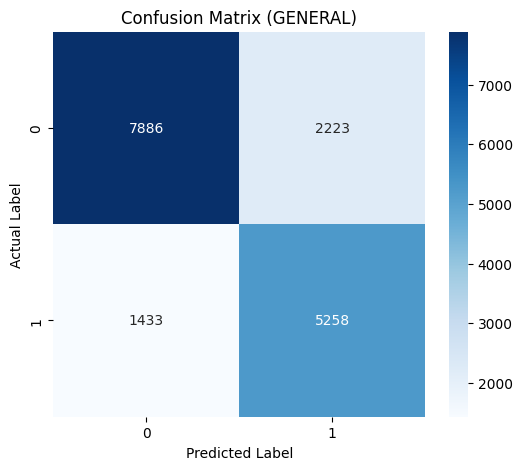

<Figure size 1000x800 with 0 Axes>

C:\Users\johnh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\johnh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\johnh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\johnh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\johnh\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 510

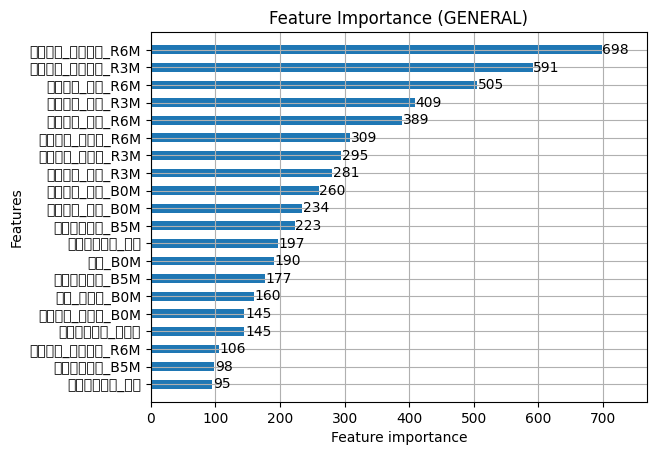

In [5]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

# =============================================================================
# [설정] 컬럼명 및 파일 경로 설정
# =============================================================================
COL_ID = '발급회원번호'
COL_DATE = '기준년월'

# 분석 변수
COL_SPEND = '이용금액_신용_B0M'      # 소비
COL_COUNT = '이용건수_신용_B0M'      # 빈도
COL_BALANCE = '잔액_B0M'             # 잔액
COL_CASH_ADV = '잔액_현금서비스_B0M' # 악성부채1
COL_CARD_LOAN = '잔액_카드론_B0M'    # 악성부채2
COL_DELINQ = '연체잔액_B0M'          # 리스크3
COL_AVG_BAL = '월중평잔'             # 자산

# Additional columns for R12M fallback
COL_SPEND_R12M = '이용금액_신용_R12M'
COL_COUNT_R12M = '이용건수_신용_R12M'

def calc_slope_long(series):
    """시계열 데이터(Series)의 선형 회귀 기울기를 계산"""
    y = series.values.astype(float)
    if len(y) < 2 or np.sum(y) == 0:
        return 0
    x = np.arange(len(y))
    slope, _, _, _, _ = linregress(x, y)
    return 0 if np.isnan(slope) else slope

def calculate_churn_scores(group):
    """고객 한 명의 데이터를 받아 점수 및 Target 생성 (1개월 이상 데이터 필요)"""
    # 데이터가 아예 없는 경우
    if len(group) < 1:
        return pd.Series({
            'Score_BadDebt': 0, 'Score_Delinq': 0, 'Score_Activity': 0, 'Score_Asset': 0,
            'Score_Status_Total': 0, 'Slope_Spend': 0, 'Slope_Balance': 0, 'Slope_Count': 0
        })

    # (A) 상태 점수 (Status Score) 세부 항목 계산
    try:
        # Helper for safe indexing
        def get_val(col, idx_from_last):
            # idx_from_last: 1 for last, 2 for 2nd last...
            if len(group) >= idx_from_last:
                return group[col].iloc[-idx_from_last]
            return 0

        # 1. [부정] 악성 부채 점수 (Score_BadDebt)
        # If only 1 month, cannot compare with previous, so score is 0
        val_last = get_val(COL_CASH_ADV, 1)
        val_prev = get_val(COL_CASH_ADV, 2)
        
        loan_last = get_val(COL_CARD_LOAN, 1)
        loan_prev = get_val(COL_CARD_LOAN, 2)
        
        bad_debt_score = (
            ((val_last - val_prev) / (val_prev + 1) * 1.5) +
            ((loan_last - loan_prev) / (loan_prev + 1) * 1.0)
        )
        
        # 2. [부정] 연체 강도 점수 (Score_Delinq)
        delinq_score = (get_val(COL_DELINQ, 1) * 3.0) + (get_val(COL_DELINQ, 2) * 2.0)
        if len(group) >= 3:
            delinq_score += (get_val(COL_DELINQ, 3) * 1.0)
        
        # 3. [긍정] 활동성 점수 (Score_Activity)
        sum_r3 = group[COL_COUNT].iloc[-3:].sum()
        sum_r6 = group[COL_COUNT].sum()
        activity_score = ((sum_r3 * 2) - sum_r6) / (sum_r6 + 1) * 100
        
        # 4. [긍정] 자산 방어 점수 (Score_Asset)
        avg_r3 = group[COL_AVG_BAL].iloc[-3:].mean()
        avg_r6 = group[COL_AVG_BAL].mean()
        asset_score = (avg_r3 / (avg_r6 + 1)) * 10
        
        # >> [Total] 상태 종합 점수 (Score_Status_Total)
        score_status_total = (bad_debt_score + delinq_score) - (activity_score + asset_score)
    except:
        bad_debt_score = 0
        delinq_score = 0
        activity_score = 0
        asset_score = 0
        score_status_total = 0

    # (B) 기울기 점수 (Slope Score)
    # CASE 1: Data >= 2 months (Use linregress)
    if len(group) >= 2:
        slope_spend = calc_slope_long(group[COL_SPEND])
        slope_balance = calc_slope_long(group[COL_BALANCE])
        slope_count = calc_slope_long(group[COL_COUNT])
    
    # CASE 2: Data == 1 month (Use R12M fallback)
    else:
        # Spending Slope Proxy: Current - Monthly_Avg(R12M)
        r12m_spend = group[COL_SPEND_R12M].iloc[0] if COL_SPEND_R12M in group.columns else 0
        avg_spend = r12m_spend / 12
        slope_spend = group[COL_SPEND].iloc[0] - avg_spend
        
        # Count Slope Proxy
        r12m_count = group[COL_COUNT_R12M].iloc[0] if COL_COUNT_R12M in group.columns else 0
        avg_count = r12m_count / 12
        slope_count = group[COL_COUNT].iloc[0] - avg_count
        
        # Balance Slope: User requested to exclude this (always satisfy).
        slope_balance = -1

    return pd.Series({
        'Score_BadDebt': bad_debt_score,
        'Score_Delinq': delinq_score,
        'Score_Activity': activity_score,
        'Score_Asset': asset_score,
        'Score_Status_Total': score_status_total,
        'Slope_Spend': slope_spend,
        'Slope_Balance': slope_balance,
        'Slope_Count': slope_count
    })

def process_data(file_path):
    print(f"\n[Info] 파일 로드 및 전처리 시작: {file_path}")
    if not os.path.exists(file_path):
        print(f"❌ 파일을 찾을 수 없습니다: {file_path}")
        return None

    # 1. 데이터 로드
    try:
        df = pd.read_csv(file_path, low_memory=False)
    except Exception as e:
        print(f"❌ 데이터 로드 실패: {e}")
        return None

    # 2. 컬럼 확인
    required_cols = [
        COL_ID, COL_DATE, COL_SPEND, COL_COUNT, COL_BALANCE, 
        COL_CASH_ADV, COL_CARD_LOAN, COL_DELINQ, COL_AVG_BAL,
        COL_SPEND_R12M, COL_COUNT_R12M
    ]
    missing_cols = [c for c in required_cols if c not in df.columns]
    if missing_cols:
        print(f"⚠️ 일부 컬럼 누락 (0으로 대체): {missing_cols}")
        for c in missing_cols:
            df[c] = 0

    # 3. 데이터 정렬
    df.sort_values(by=[COL_ID, COL_DATE], inplace=True)
    
    print(" - 고객별 지표(Slopes, Scores) 산출 중... (R12M 보완 로직 적용됨)")
    df_scores = df.groupby(COL_ID).apply(calculate_churn_scores).reset_index()
    
    # 4. Target 생성 로직 적용
    print(" - Target 생성 중...")
    
    # (조건 A) 기울기 3종(소비, 잔액, 건수)이 모두 0 이하
    cond_slopes_decrease = (
        (df_scores['Slope_Spend'] <= 0) & 
        (df_scores['Slope_Balance'] <= 0) & 
        (df_scores['Slope_Count'] <= 0)
    )
    
    # (조건 B) 4대 위험 징후 중 1개 이상 감지
    cond1 = df_scores['Score_BadDebt'] > 0
    cond2 = df_scores['Score_Delinq'] > 0
    cond3 = df_scores['Score_Activity'] < 0
    cond4 = df_scores['Score_Asset'] == 0
    
    risk_count = cond1.astype(int) + cond2.astype(int) + cond3.astype(int) + cond4.astype(int)
    cond_high_risk = (risk_count >= 1)
    
    # Target 할당
    df_scores['Target'] = np.where(cond_slopes_decrease & cond_high_risk, 1, 0)
    
    print(f" - 완료: {len(df_scores)}명 데이터 생성됨.")
    print(f" - Target 비율: {df_scores['Target'].value_counts(normalize=True).to_dict()}")
    
    return df_scores

def train_eval_lgbm_general_group_split(input_data, group_name='GENERAL', device_type='cpu'):
    print(f"\n{'='*20} [{group_name}] Training Start (Group-based Split) {'='*20}")
    
    # 1. 데이터 준비
    if input_data is None:
        print("❌ 입력 데이터가 없습니다 (None). 앞 단계의 추출 결과를 확인해주세요.")
        return None, None
        
    df_train = input_data.copy()

    # 2. Leakage 변수 정의 (제거 대상)
    
    leakage_cols = [
        'Target', '발급회원번호', 'Unnamed: 0',
        'Slope_Spend', 'Slope_Balance', 'Slope_Count', 
        'Norm_Slope_Spend', 'Norm_Slope_Balance', 'Norm_Slope_Count',
        'Score_BadDebt', 'Score_Delinq', 'Score_Activity', 'Score_Asset',
        'Score_Status_Total', 'Score_Slope_Total', 'Final_Total_Score',
        'Risk_Count', 'Churn_Segment',
        'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero',
        '이용건수_신용_R6M', '이용건수_신용_R3M', '이용건수_일시불_R6M', '이용건수_신판_R3M', '이용건수_신판_R6M', '이용건수_신용_B0M',
        '이용건수_일시불_R3M'
    ]
    
    if 'Target' not in df_train.columns:
        print("❌ 'Target' 컬럼이 없습니다.")
        return None, None
        
    # 3. Train / Test Split (Group Split 적용)
    print(" - [Info] Group-based Split 적용 (발급회원번호 기준)")
    
    unique_user_target = df_train[['발급회원번호', 'Target']].drop_duplicates(subset=['발급회원번호'])
    
    try:
        train_ids, test_ids = train_test_split(
            unique_user_target['발급회원번호'], 
            test_size=0.2, 
            random_state=42, 
            stratify=unique_user_target['Target']
        )
    except ValueError as e:
        print(f"⚠️ Stratified split failed (probably too few samples of one class). Using random split. Error: {e}")
        train_ids, test_ids = train_test_split(
            unique_user_target['발급회원번호'], 
            test_size=0.2, 
            random_state=42
        )
    
    df_train_sub = df_train[df_train['발급회원번호'].isin(train_ids)]
    df_test_sub = df_train[df_train['발급회원번호'].isin(test_ids)]
    
    print(f" - Train 회원 수: {len(train_ids)}명, Test 회원 수: {len(test_ids)}명")
    print(f" - Train 데이터 수: {len(df_train_sub)}개, Test 데이터 수: {len(df_test_sub)}개")

    # X, y 생성
    # Drop leakage columns carefully (ignore if not present)
    cols_to_drop = [c for c in leakage_cols if c in df_train.columns]
    
    X_train = df_train_sub.drop(columns=cols_to_drop).select_dtypes(include=['number'])
    y_train = df_train_sub['Target']
    
    X_test = df_test_sub.drop(columns=cols_to_drop).select_dtypes(include=['number'])
    y_test = df_test_sub['Target']

    print(f" - 최종 학습 Feature 수: {X_train.shape[1]}개")

    # 4. LightGBM 파라미터
    params = {
        'n_estimators': 400,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'max_depth': -1,
        'random_state': 42,
        'n_jobs': -1,
        'device': device_type,
        'verbose': -1,
        'class_weight': 'balanced'
    }
    
    if device_type == 'gpu':
        params['gpu_platform_id'] = 0
        params['gpu_device_id'] = 0

    model = lgb.LGBMClassifier(**params)
    
    # 5. 모델 학습
    start_time = time.time()
    try:
        model.fit(X_train, y_train)
    except Exception as e:
        print(f"⚠️ 학습 중 에러 발생 ({e}). CPU 모드로 전환하여 재시도합니다.")
        params['device'] = 'cpu'
        if 'gpu_platform_id' in params: del params['gpu_platform_id']
        if 'gpu_device_id' in params: del params['gpu_device_id']
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train)
            
    elapsed = time.time() - start_time
    print(f"✅ 학습 완료 (소요시간: {elapsed:.2f}초)")

    # 6. 성능 평가
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    try:
        auc = roc_auc_score(y_test, y_prob)
    except:
        auc = 0.0

    print(f"\n📊 [{group_name}] Model Performance Report")
    print(f" - Accuracy  : {acc:.4f}")
    print(f" - F1 Score  : {f1:.4f}")
    print(f" - ROC-AUC   : {auc:.4f}")
    print("-" * 50)
    print(classification_report(y_test, y_pred))

        # Confusion Matrix 시각화
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix ({group_name})')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Feature Importance 시각화 (Top 20)
    plt.figure(figsize=(10, 8))
    lgb.plot_importance(model, max_num_features=20, height=0.5, title=f'Feature Importance ({group_name})')
    plt.show()

    return model, (acc, f1, auc)

def process_data_and_merge(file_path):
    # This function needs to return a DF that has both FEATURES (raw) and TARGET.
    
    print(f"\n[Info] 파일 로드 및 전처리 시작: {file_path}")
    if not os.path.exists(file_path):
        print(f"❌ 파일을 찾을 수 없습니다: {file_path}")
        return None

    # 1. Load
    try:
        df = pd.read_csv(file_path, low_memory=False)
    except Exception as e:
        print(f"❌ 데이터 로드 실패: {e}")
        return None
    
    # Check R12M cols presence for scoring
    # (If missing, default to 0 for calculations)
    if COL_SPEND_R12M not in df.columns: df[COL_SPEND_R12M] = 0
    if COL_COUNT_R12M not in df.columns: df[COL_COUNT_R12M] = 0

    # 2. Sort
    df.sort_values(by=[COL_ID, COL_DATE], inplace=True)
    
    # 3. Calculate Scores (Target Logic)
    print(" - Target 산출 (R12M 보완 로직)...")
    df_scores = df.groupby(COL_ID).apply(calculate_churn_scores).reset_index()
    
    # Generate Target
    # (조건 A)
    cond_slopes_decrease = (
        (df_scores['Slope_Spend'] <= 0) & 
        (df_scores['Slope_Balance'] <= 0) & 
        (df_scores['Slope_Count'] <= 0)
    )
    # (조건 B)
    cond1 = df_scores['Score_BadDebt'] > 0
    cond2 = df_scores['Score_Delinq'] > 0
    cond3 = df_scores['Score_Activity'] < 0
    cond4 = df_scores['Score_Asset'] == 0
    risk_count = cond1.astype(int) + cond2.astype(int) + cond3.astype(int) + cond4.astype(int)
    cond_high_risk = (risk_count >= 1)
    
    df_scores['Target'] = np.where(cond_slopes_decrease & cond_high_risk, 1, 0)
    
    print(f" - Target 생성 완료. 비율: {df_scores['Target'].value_counts(normalize=True).to_dict()}")
    
    # 4. Prepare Training Data
    # Option: Use the Last Row of each user as features
    print(" - 학습용 데이터셋 구성 (각 고객의 마지막 월 데이터 사용)...")
    df_last = df.groupby(COL_ID).tail(1).copy()
    
    # Merge Target
    df_final = df_last.merge(df_scores[[COL_ID, 'Target']], on=COL_ID, how='left')
    
    return df_final

if __name__ == "__main__":
    # 파일 경로 (수정 필요)
    TRAIN_FILE = '../../../260108/general_combined_part1.csv' # Example file
    
    # 1. Process Data
    df_train_final = process_data_and_merge(TRAIN_FILE)
    
    # 2. Train Model
    if df_train_final is not None:
        model, res = train_eval_lgbm_general_group_split(df_train_final)


In [7]:
def train_eval_lgbm_general_group_split(input_data, group_name='GENERAL', device_type='cpu'):
    print(f"\n{'='*20} [{group_name}] Training Start (Group-based Split) {'='*20}")
    
    # 1. 데이터 준비
    if input_data is None:
        print("❌ 입력 데이터가 없습니다 (None). 앞 단계의 추출 결과를 확인해주세요.")
        return None, None
        
    df_train = input_data.copy()

    # 2. Leakage 변수 정의 (제거 대상)
    leakage_cols = [
        'Target', '발급회원번호', 'Unnamed: 0',
        'Slope_Spend', 'Slope_Balance', 'Slope_Count', 
        'Norm_Slope_Spend', 'Norm_Slope_Balance', 'Norm_Slope_Count',
        'Score_BadDebt', 'Score_Delinq', 'Score_Activity', 'Score_Asset',
        'Score_Status_Total', 'Score_Slope_Total', 'Final_Total_Score',
        'Risk_Count', 'Churn_Segment',
        'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero',
        '이용건수_신용_R6M', '이용건수_신용_R3M', '이용건수_일시불_R6M', '이용건수_신판_R3M', '이용건수_신판_R6M', '이용건수_신용_B0M',
        '이용건수_일시불_R3M'
    ]
    
    if 'Target' not in df_train.columns:
        print("❌ 'Target' 컬럼이 없습니다.")
        return None, None
        
    # 3. Train / Test Split (Group Split 적용)
    print(" - [Info] Group-based Split 적용 (발급회원번호 기준)")
    
    unique_user_target = df_train[['발급회원번호', 'Target']].drop_duplicates(subset=['발급회원번호'])
    
    try:
        train_ids, test_ids = train_test_split(
            unique_user_target['발급회원번호'], 
            test_size=0.2, 
            random_state=42, 
            stratify=unique_user_target['Target']
        )
    except ValueError as e:
        print(f"⚠️ Stratified split failed. Using random split. Error: {e}")
        train_ids, test_ids = train_test_split(
            unique_user_target['발급회원번호'], 
            test_size=0.2, 
            random_state=42
        )
    
    df_train_sub = df_train[df_train['발급회원번호'].isin(train_ids)]
    df_test_sub = df_train[df_train['발급회원번호'].isin(test_ids)]
    
    print(f" - Train 회원 수: {len(train_ids)}명, Test 회원 수: {len(test_ids)}명")
    print(f" - Train 데이터 수: {len(df_train_sub)}개, Test 데이터 수: {len(df_test_sub)}개")

    # X, y 생성
    cols_to_drop = [c for c in leakage_cols if c in df_train.columns]
    
    X_train = df_train_sub.drop(columns=cols_to_drop).select_dtypes(include=['number'])
    y_train = df_train_sub['Target']
    
    X_test = df_test_sub.drop(columns=cols_to_drop).select_dtypes(include=['number'])
    y_test = df_test_sub['Target']

    print(f" - 최종 학습 Feature 수: {X_train.shape[1]}개")

    # =========================================================
    # [수정] scale_pos_weight 자동 계산 로직 추가
    # =========================================================
    n_positive = y_train.sum()
    n_negative = len(y_train) - n_positive
    
    # 기본 비율 계산 (Negative 수 / Positive 수)
    # 0으로 나누는 것을 방지하기 위한 안전장치 추가
    ratio = n_negative / n_positive if n_positive > 0 else 1.0
    
    # 튜닝 포인트: 이탈자를 더 강력하게 잡고 싶다면 ratio * 1.5, ratio * 2.0 등으로 높이세요.
    final_scale_pos_weight = ratio * 1.2 
    
    print(f" - [Info] 자동 계산된 Class Ratio (Neg/Pos): {ratio:.2f}")
    print(f" - [Info] 적용된 scale_pos_weight: {final_scale_pos_weight:.2f}")
    # =========================================================

    # 4. LightGBM 파라미터
    params = {
        'n_estimators': 400,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'max_depth': -1,
        'random_state': 42,
        'n_jobs': -1,
        'device': device_type,
        'verbose': -1,
        # 'class_weight': 'balanced',    <-- [삭제] 이것 대신 아래 scale_pos_weight 사용
        'scale_pos_weight': final_scale_pos_weight  # <-- [추가]
    }
    
    if device_type == 'gpu':
        params['gpu_platform_id'] = 0
        params['gpu_device_id'] = 0

    model = lgb.LGBMClassifier(**params)
    
    # 5. 모델 학습
    start_time = time.time()
    try:
        model.fit(X_train, y_train)
    except Exception as e:
        print(f"⚠️ 학습 중 에러 발생 ({e}). CPU 모드로 전환하여 재시도합니다.")
        params['device'] = 'cpu'
        if 'gpu_platform_id' in params: del params['gpu_platform_id']
        if 'gpu_device_id' in params: del params['gpu_device_id']
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train)
            
    elapsed = time.time() - start_time
    print(f"✅ 학습 완료 (소요시간: {elapsed:.2f}초)")

    # 6. 성능 평가
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    try:
        auc = roc_auc_score(y_test, y_prob)
    except:
        auc = 0.0

    print(f"\n📊 [{group_name}] Model Performance Report")
    print(f" - Accuracy  : {acc:.4f}")
    print(f" - F1 Score  : {f1:.4f}")
    print(f" - ROC-AUC   : {auc:.4f}")
    print("-" * 50)
    print(classification_report(y_test, y_pred))

    # Confusion Matrix 시각화
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix ({group_name})')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Feature Importance 시각화 (Top 20)
    plt.figure(figsize=(10, 8))
    lgb.plot_importance(model, max_num_features=20, height=0.5, title=f'Feature Importance ({group_name})')
    plt.show()

    return model, (acc, f1, auc)

### class_weight 가중치 balance 에서 직접 부여
- 1.2


[Info] 파일 로드 및 전처리 시작: ../../../260108/general_combined_part1.csv
 - Target 산출 (R12M 보완 로직)...


C:\Users\johnh\AppData\Local\Temp\ipykernel_27772\2519724740.py:79: RuntimeWarning: divide by zero encountered in scalar divide
  activity_score = ((sum_r3 * 2) - sum_r6) / (sum_r6 + 1) * 100
C:\Users\johnh\AppData\Local\Temp\ipykernel_27772\2519724740.py:345: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_scores = df.groupby(COL_ID).apply(calculate_churn_scores).reset_index()


 - Target 생성 완료. 비율: {0: 0.6017261904761905, 1: 0.39827380952380953}
 - 학습용 데이터셋 구성 (각 고객의 마지막 월 데이터 사용)...

==================== [GENERAL] Training Start (Group-based Split) ====================
 - [Info] Group-based Split 적용 (발급회원번호 기준)
 - Train 회원 수: 67200명, Test 회원 수: 16800명
 - Train 데이터 수: 67200개, Test 데이터 수: 16800개
 - 최종 학습 Feature 수: 810개
 - [Info] 자동 계산된 Class Ratio (Neg/Pos): 1.51
 - [Info] 적용된 scale_pos_weight: 1.81
✅ 학습 완료 (소요시간: 11.14초)

📊 [GENERAL] Model Performance Report
 - Accuracy  : 0.7765
 - F1 Score  : 0.7788
 - ROC-AUC   : 0.8743
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.74      0.80     10109
           1       0.68      0.83      0.75      6691

    accuracy                           0.78     16800
   macro avg       0.77      0.79      0.77     16800
weighted avg       0.79      0.78      0.78     16800



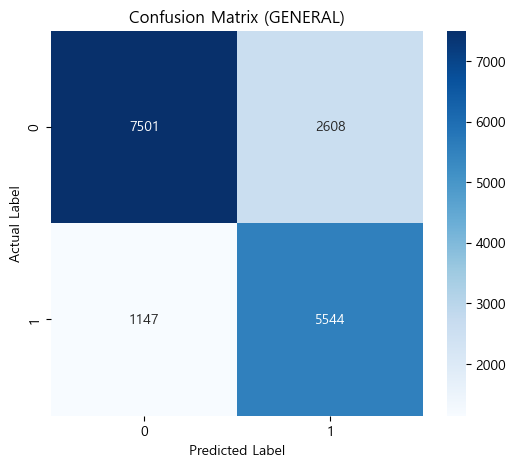

<Figure size 1000x800 with 0 Axes>

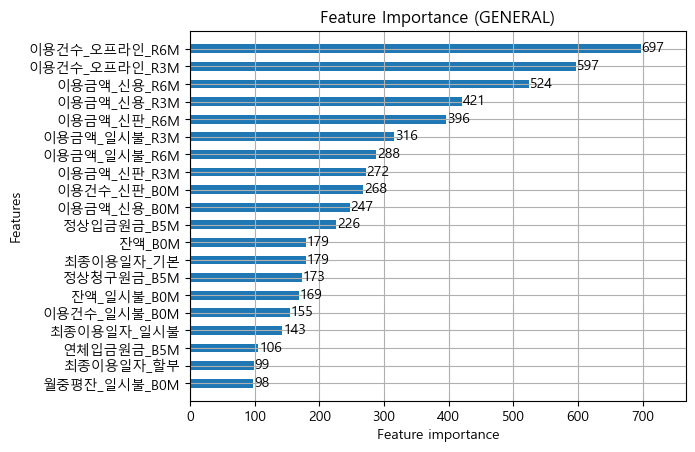

In [8]:
# TRAIN_FILE = 'general_combined_part1.csv' # Example file

# 1. Process Data
df_train_final = process_data_and_merge(TRAIN_FILE)

# 2. Train Model
if df_train_final is not None:
    model, res = train_eval_lgbm_general_group_split(df_train_final)

#### 1.5

In [9]:
def train_eval_lgbm_general_group_split(input_data, group_name='GENERAL', device_type='cpu'):
    print(f"\n{'='*20} [{group_name}] Training Start (Group-based Split) {'='*20}")
    
    # 1. 데이터 준비
    if input_data is None:
        print("❌ 입력 데이터가 없습니다 (None). 앞 단계의 추출 결과를 확인해주세요.")
        return None, None
        
    df_train = input_data.copy()

    # 2. Leakage 변수 정의 (제거 대상)
    leakage_cols = [
        'Target', '발급회원번호', 'Unnamed: 0',
        'Slope_Spend', 'Slope_Balance', 'Slope_Count', 
        'Norm_Slope_Spend', 'Norm_Slope_Balance', 'Norm_Slope_Count',
        'Score_BadDebt', 'Score_Delinq', 'Score_Activity', 'Score_Asset',
        'Score_Status_Total', 'Score_Slope_Total', 'Final_Total_Score',
        'Risk_Count', 'Churn_Segment',
        'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero',
        '이용건수_신용_R6M', '이용건수_신용_R3M', '이용건수_일시불_R6M', '이용건수_신판_R3M', '이용건수_신판_R6M', '이용건수_신용_B0M',
        '이용건수_일시불_R3M'
    ]
    
    if 'Target' not in df_train.columns:
        print("❌ 'Target' 컬럼이 없습니다.")
        return None, None
        
    # 3. Train / Test Split (Group Split 적용)
    print(" - [Info] Group-based Split 적용 (발급회원번호 기준)")
    
    unique_user_target = df_train[['발급회원번호', 'Target']].drop_duplicates(subset=['발급회원번호'])
    
    try:
        train_ids, test_ids = train_test_split(
            unique_user_target['발급회원번호'], 
            test_size=0.2, 
            random_state=42, 
            stratify=unique_user_target['Target']
        )
    except ValueError as e:
        print(f"⚠️ Stratified split failed. Using random split. Error: {e}")
        train_ids, test_ids = train_test_split(
            unique_user_target['발급회원번호'], 
            test_size=0.2, 
            random_state=42
        )
    
    df_train_sub = df_train[df_train['발급회원번호'].isin(train_ids)]
    df_test_sub = df_train[df_train['발급회원번호'].isin(test_ids)]
    
    print(f" - Train 회원 수: {len(train_ids)}명, Test 회원 수: {len(test_ids)}명")
    print(f" - Train 데이터 수: {len(df_train_sub)}개, Test 데이터 수: {len(df_test_sub)}개")

    # X, y 생성
    cols_to_drop = [c for c in leakage_cols if c in df_train.columns]
    
    X_train = df_train_sub.drop(columns=cols_to_drop).select_dtypes(include=['number'])
    y_train = df_train_sub['Target']
    
    X_test = df_test_sub.drop(columns=cols_to_drop).select_dtypes(include=['number'])
    y_test = df_test_sub['Target']

    print(f" - 최종 학습 Feature 수: {X_train.shape[1]}개")

    # =========================================================
    # [수정] scale_pos_weight 자동 계산 로직 추가
    # =========================================================
    n_positive = y_train.sum()
    n_negative = len(y_train) - n_positive
    
    # 기본 비율 계산 (Negative 수 / Positive 수)
    # 0으로 나누는 것을 방지하기 위한 안전장치 추가
    ratio = n_negative / n_positive if n_positive > 0 else 1.0
    
    # 튜닝 포인트: 이탈자를 더 강력하게 잡고 싶다면 ratio * 1.5, ratio * 2.0 등으로 높이세요.
    final_scale_pos_weight = ratio * 1.5 
    
    print(f" - [Info] 자동 계산된 Class Ratio (Neg/Pos): {ratio:.2f}")
    print(f" - [Info] 적용된 scale_pos_weight: {final_scale_pos_weight:.2f}")
    # =========================================================

    # 4. LightGBM 파라미터
    params = {
        'n_estimators': 400,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'max_depth': -1,
        'random_state': 42,
        'n_jobs': -1,
        'device': device_type,
        'verbose': -1,
        # 'class_weight': 'balanced',    <-- [삭제] 이것 대신 아래 scale_pos_weight 사용
        'scale_pos_weight': final_scale_pos_weight  # <-- [추가]
    }
    
    if device_type == 'gpu':
        params['gpu_platform_id'] = 0
        params['gpu_device_id'] = 0

    model = lgb.LGBMClassifier(**params)
    
    # 5. 모델 학습
    start_time = time.time()
    try:
        model.fit(X_train, y_train)
    except Exception as e:
        print(f"⚠️ 학습 중 에러 발생 ({e}). CPU 모드로 전환하여 재시도합니다.")
        params['device'] = 'cpu'
        if 'gpu_platform_id' in params: del params['gpu_platform_id']
        if 'gpu_device_id' in params: del params['gpu_device_id']
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train)
            
    elapsed = time.time() - start_time
    print(f"✅ 학습 완료 (소요시간: {elapsed:.2f}초)")

    # 6. 성능 평가
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    try:
        auc = roc_auc_score(y_test, y_prob)
    except:
        auc = 0.0

    print(f"\n📊 [{group_name}] Model Performance Report")
    print(f" - Accuracy  : {acc:.4f}")
    print(f" - F1 Score  : {f1:.4f}")
    print(f" - ROC-AUC   : {auc:.4f}")
    print("-" * 50)
    print(classification_report(y_test, y_pred))

    # Confusion Matrix 시각화
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix ({group_name})')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Feature Importance 시각화 (Top 20)
    plt.figure(figsize=(10, 8))
    lgb.plot_importance(model, max_num_features=20, height=0.5, title=f'Feature Importance ({group_name})')
    plt.show()

    return model, (acc, f1, auc)


==================== [GENERAL] Training Start (Group-based Split) ====================
 - [Info] Group-based Split 적용 (발급회원번호 기준)
 - Train 회원 수: 67200명, Test 회원 수: 16800명
 - Train 데이터 수: 67200개, Test 데이터 수: 16800개
 - 최종 학습 Feature 수: 810개
 - [Info] 자동 계산된 Class Ratio (Neg/Pos): 1.51
 - [Info] 적용된 scale_pos_weight: 2.27
✅ 학습 완료 (소요시간: 7.89초)

📊 [GENERAL] Model Performance Report
 - Accuracy  : 0.7660
 - F1 Score  : 0.7681
 - ROC-AUC   : 0.8749
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.69      0.78     10109
           1       0.65      0.88      0.75      6691

    accuracy                           0.77     16800
   macro avg       0.77      0.78      0.76     16800
weighted avg       0.80      0.77      0.77     16800



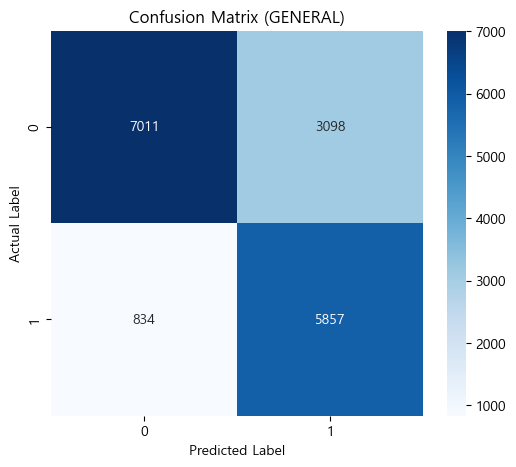

<Figure size 1000x800 with 0 Axes>

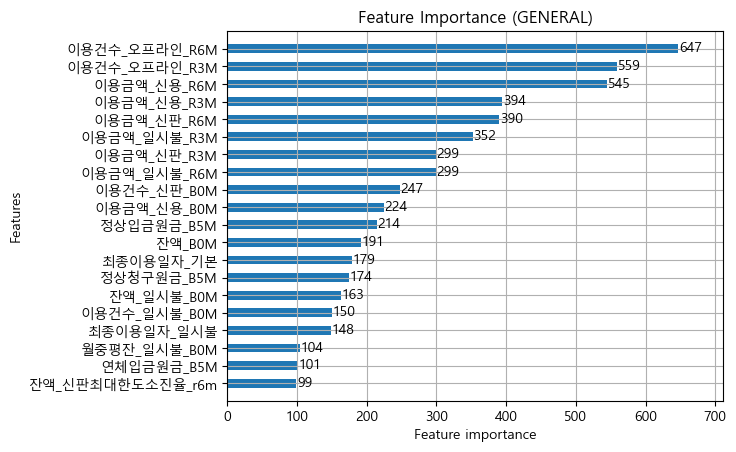

In [10]:
# TRAIN_FILE = 'general_combined_part1.csv' # Example file

# 1. Process Data
# df_train_final = process_data_and_merge(TRAIN_FILE)

# 2. Train Model
if df_train_final is not None:
    model, res = train_eval_lgbm_general_group_split(df_train_final)

## 이탈자 status score 2 이상
- 모델형성

In [11]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os

# =============================================================================
# [설정] 컬럼명 및 파일 경로 설정
# =============================================================================
COL_ID = '발급회원번호'
COL_DATE = '기준년월'

# 분석 변수
COL_SPEND = '이용금액_신용_B0M'      # 소비
COL_COUNT = '이용건수_신용_B0M'      # 빈도
COL_BALANCE = '잔액_B0M'             # 잔액
COL_CASH_ADV = '잔액_현금서비스_B0M' # 악성부채1
COL_CARD_LOAN = '잔액_카드론_B0M'    # 악성부채2
COL_DELINQ = '연체잔액_B0M'          # 리스크3
COL_AVG_BAL = '월중평잔'             # 자산

# Additional columns for R12M fallback
COL_SPEND_R12M = '이용금액_신용_R12M'
COL_COUNT_R12M = '이용건수_신용_R12M'

def calc_slope_long(series):
    """시계열 데이터(Series)의 선형 회귀 기울기를 계산"""
    y = series.values.astype(float)
    if len(y) < 2 or np.sum(y) == 0:
        return 0
    x = np.arange(len(y))
    slope, _, _, _, _ = linregress(x, y)
    return 0 if np.isnan(slope) else slope

def calculate_churn_scores(group):
    """고객 한 명의 데이터를 받아 점수 및 Target 생성 (1개월 이상 데이터 필요)"""
    # 데이터가 아예 없는 경우
    if len(group) < 1:
        return pd.Series({
            'Score_BadDebt': 0, 'Score_Delinq': 0, 'Score_Activity': 0, 'Score_Asset': 0,
            'Score_Status_Total': 0, 'Slope_Spend': 0, 'Slope_Balance': 0, 'Slope_Count': 0
        })

    # (A) 상태 점수 (Status Score) 세부 항목 계산
    try:
        # Helper for safe indexing
        def get_val(col, idx_from_last):
            # idx_from_last: 1 for last, 2 for 2nd last...
            if len(group) >= idx_from_last:
                return group[col].iloc[-idx_from_last]
            return 0

        # 1. [부정] 악성 부채 점수 (Score_BadDebt)
        # If only 1 month, cannot compare with previous, so score is 0
        val_last = get_val(COL_CASH_ADV, 1)
        val_prev = get_val(COL_CASH_ADV, 2)
        
        loan_last = get_val(COL_CARD_LOAN, 1)
        loan_prev = get_val(COL_CARD_LOAN, 2)
        
        bad_debt_score = (
            ((val_last - val_prev) / (val_prev + 1) * 1.5) +
            ((loan_last - loan_prev) / (loan_prev + 1) * 1.0)
        )
        
        # 2. [부정] 연체 강도 점수 (Score_Delinq)
        delinq_score = (get_val(COL_DELINQ, 1) * 3.0) + (get_val(COL_DELINQ, 2) * 2.0)
        if len(group) >= 3:
            delinq_score += (get_val(COL_DELINQ, 3) * 1.0)
        
        # 3. [긍정] 활동성 점수 (Score_Activity)
        sum_r3 = group[COL_COUNT].iloc[-3:].sum()
        sum_r6 = group[COL_COUNT].sum()
        activity_score = ((sum_r3 * 2) - sum_r6) / (sum_r6 + 1) * 100
        
        # 4. [긍정] 자산 방어 점수 (Score_Asset)
        avg_r3 = group[COL_AVG_BAL].iloc[-3:].mean()
        avg_r6 = group[COL_AVG_BAL].mean()
        asset_score = (avg_r3 / (avg_r6 + 1)) * 10
        
        # >> [Total] 상태 종합 점수 (Score_Status_Total)
        score_status_total = (bad_debt_score + delinq_score) - (activity_score + asset_score)
    except:
        bad_debt_score = 0
        delinq_score = 0
        activity_score = 0
        asset_score = 0
        score_status_total = 0

    # (B) 기울기 점수 (Slope Score)
    # CASE 1: Data >= 2 months (Use linregress)
    if len(group) >= 2:
        slope_spend = calc_slope_long(group[COL_SPEND])
        slope_balance = calc_slope_long(group[COL_BALANCE])
        slope_count = calc_slope_long(group[COL_COUNT])
    
    # CASE 2: Data == 1 month (Use R12M fallback)
    else:
        # Spending Slope Proxy: Current - Monthly_Avg(R12M)
        r12m_spend = group[COL_SPEND_R12M].iloc[0] if COL_SPEND_R12M in group.columns else 0
        avg_spend = r12m_spend / 12
        slope_spend = group[COL_SPEND].iloc[0] - avg_spend
        
        # Count Slope Proxy
        r12m_count = group[COL_COUNT_R12M].iloc[0] if COL_COUNT_R12M in group.columns else 0
        avg_count = r12m_count / 12
        slope_count = group[COL_COUNT].iloc[0] - avg_count
        
        # Balance Slope: User requested to exclude this (always satisfy).
        slope_balance = -1

    return pd.Series({
        'Score_BadDebt': bad_debt_score,
        'Score_Delinq': delinq_score,
        'Score_Activity': activity_score,
        'Score_Asset': asset_score,
        'Score_Status_Total': score_status_total,
        'Slope_Spend': slope_spend,
        'Slope_Balance': slope_balance,
        'Slope_Count': slope_count
    })

def process_data(file_path):
    print(f"\n[Info] 파일 로드 및 전처리 시작: {file_path}")
    if not os.path.exists(file_path):
        print(f"❌ 파일을 찾을 수 없습니다: {file_path}")
        return None

    # 1. 데이터 로드
    try:
        df = pd.read_csv(file_path, low_memory=False)
    except Exception as e:
        print(f"❌ 데이터 로드 실패: {e}")
        return None

    # 2. 컬럼 확인
    required_cols = [
        COL_ID, COL_DATE, COL_SPEND, COL_COUNT, COL_BALANCE, 
        COL_CASH_ADV, COL_CARD_LOAN, COL_DELINQ, COL_AVG_BAL,
        COL_SPEND_R12M, COL_COUNT_R12M
    ]
    missing_cols = [c for c in required_cols if c not in df.columns]
    if missing_cols:
        print(f"⚠️ 일부 컬럼 누락 (0으로 대체): {missing_cols}")
        for c in missing_cols:
            df[c] = 0

    # 3. 데이터 정렬
    df.sort_values(by=[COL_ID, COL_DATE], inplace=True)
    
    print(" - 고객별 지표(Slopes, Scores) 산출 중... (R12M 보완 로직 적용됨)")
    df_scores = df.groupby(COL_ID).apply(calculate_churn_scores).reset_index()
    
    # 4. Target 생성 로직 적용
    print(" - Target 생성 중...")
    
    # (조건 A) 기울기 3종(소비, 잔액, 건수)이 모두 0 이하
    cond_slopes_decrease = (
        (df_scores['Slope_Spend'] <= 0) & 
        (df_scores['Slope_Balance'] <= 0) & 
        (df_scores['Slope_Count'] <= 0)
    )
    
    # (조건 B) 4대 위험 징후 중 1개 이상 감지
    cond1 = df_scores['Score_BadDebt'] > 0
    cond2 = df_scores['Score_Delinq'] > 0
    cond3 = df_scores['Score_Activity'] < 0
    cond4 = df_scores['Score_Asset'] == 0
    
    risk_count = cond1.astype(int) + cond2.astype(int) + cond3.astype(int) + cond4.astype(int)
    cond_high_risk = (risk_count >= 2)
    
    # Target 할당
    df_scores['Target'] = np.where(cond_slopes_decrease & cond_high_risk, 1, 0)
    
    print(f" - 완료: {len(df_scores)}명 데이터 생성됨.")
    print(f" - Target 비율: {df_scores['Target'].value_counts(normalize=True).to_dict()}")
    
    return df_scores

def train_eval_lgbm_general_group_split(input_data, group_name='GENERAL', device_type='cpu'):
    print(f"\n{'='*20} [{group_name}] Training Start (Group-based Split) {'='*20}")
    
    # 1. 데이터 준비
    if input_data is None:
        print("❌ 입력 데이터가 없습니다 (None). 앞 단계의 추출 결과를 확인해주세요.")
        return None, None
        
    df_train = input_data.copy()

    # 2. Leakage 변수 정의 (제거 대상)
    
    leakage_cols = [
        'Target', '발급회원번호', 'Unnamed: 0',
        'Slope_Spend', 'Slope_Balance', 'Slope_Count', 
        'Norm_Slope_Spend', 'Norm_Slope_Balance', 'Norm_Slope_Count',
        'Score_BadDebt', 'Score_Delinq', 'Score_Activity', 'Score_Asset',
        'Score_Status_Total', 'Score_Slope_Total', 'Final_Total_Score',
        'Risk_Count', 'Churn_Segment',
        'Cond1_Has_BadDebt', 'Cond2_Has_Delinq', 'Cond3_Activity_Drop', 'Cond4_Asset_Zero',
        '이용건수_신용_R6M', '이용건수_신용_R3M', '이용건수_일시불_R6M', '이용건수_신판_R3M', '이용건수_신판_R6M', '이용건수_신용_B0M',
        '이용건수_일시불_R3M'
    ]
    
    if 'Target' not in df_train.columns:
        print("❌ 'Target' 컬럼이 없습니다.")
        return None, None
        
    # 3. Train / Test Split (Group Split 적용)
    print(" - [Info] Group-based Split 적용 (발급회원번호 기준)")
    
    unique_user_target = df_train[['발급회원번호', 'Target']].drop_duplicates(subset=['발급회원번호'])
    
    try:
        train_ids, test_ids = train_test_split(
            unique_user_target['발급회원번호'], 
            test_size=0.2, 
            random_state=42, 
            stratify=unique_user_target['Target']
        )
    except ValueError as e:
        print(f"⚠️ Stratified split failed (probably too few samples of one class). Using random split. Error: {e}")
        train_ids, test_ids = train_test_split(
            unique_user_target['발급회원번호'], 
            test_size=0.2, 
            random_state=42
        )
    
    df_train_sub = df_train[df_train['발급회원번호'].isin(train_ids)]
    df_test_sub = df_train[df_train['발급회원번호'].isin(test_ids)]
    
    print(f" - Train 회원 수: {len(train_ids)}명, Test 회원 수: {len(test_ids)}명")
    print(f" - Train 데이터 수: {len(df_train_sub)}개, Test 데이터 수: {len(df_test_sub)}개")

    # X, y 생성
    # Drop leakage columns carefully (ignore if not present)
    cols_to_drop = [c for c in leakage_cols if c in df_train.columns]
    
    X_train = df_train_sub.drop(columns=cols_to_drop).select_dtypes(include=['number'])
    y_train = df_train_sub['Target']
    
    X_test = df_test_sub.drop(columns=cols_to_drop).select_dtypes(include=['number'])
    y_test = df_test_sub['Target']

    print(f" - 최종 학습 Feature 수: {X_train.shape[1]}개")

    # 4. LightGBM 파라미터
    params = {
        'n_estimators': 400,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'max_depth': -1,
        'random_state': 42,
        'n_jobs': -1,
        'device': device_type,
        'verbose': -1,
        'class_weight': 'balanced'
    }
    
    if device_type == 'gpu':
        params['gpu_platform_id'] = 0
        params['gpu_device_id'] = 0

    model = lgb.LGBMClassifier(**params)
    
    # 5. 모델 학습
    start_time = time.time()
    try:
        model.fit(X_train, y_train)
    except Exception as e:
        print(f"⚠️ 학습 중 에러 발생 ({e}). CPU 모드로 전환하여 재시도합니다.")
        params['device'] = 'cpu'
        if 'gpu_platform_id' in params: del params['gpu_platform_id']
        if 'gpu_device_id' in params: del params['gpu_device_id']
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train)
            
    elapsed = time.time() - start_time
    print(f"✅ 학습 완료 (소요시간: {elapsed:.2f}초)")

    # 6. 성능 평가
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    try:
        auc = roc_auc_score(y_test, y_prob)
    except:
        auc = 0.0

    print(f"\n📊 [{group_name}] Model Performance Report")
    print(f" - Accuracy  : {acc:.4f}")
    print(f" - F1 Score  : {f1:.4f}")
    print(f" - ROC-AUC   : {auc:.4f}")
    print("-" * 50)
    print(classification_report(y_test, y_pred))

        # Confusion Matrix 시각화
    plt.figure(figsize=(6, 5))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix ({group_name})')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Feature Importance 시각화 (Top 20)
    plt.figure(figsize=(10, 8))
    lgb.plot_importance(model, max_num_features=20, height=0.5, title=f'Feature Importance ({group_name})')
    plt.show()

    return model, (acc, f1, auc)

def process_data_and_merge(file_path):
    # This function needs to return a DF that has both FEATURES (raw) and TARGET.
    
    print(f"\n[Info] 파일 로드 및 전처리 시작: {file_path}")
    if not os.path.exists(file_path):
        print(f"❌ 파일을 찾을 수 없습니다: {file_path}")
        return None

    # 1. Load
    try:
        df = pd.read_csv(file_path, low_memory=False)
    except Exception as e:
        print(f"❌ 데이터 로드 실패: {e}")
        return None
    
    # Check R12M cols presence for scoring
    # (If missing, default to 0 for calculations)
    if COL_SPEND_R12M not in df.columns: df[COL_SPEND_R12M] = 0
    if COL_COUNT_R12M not in df.columns: df[COL_COUNT_R12M] = 0

    # 2. Sort
    df.sort_values(by=[COL_ID, COL_DATE], inplace=True)
    
    # 3. Calculate Scores (Target Logic)
    print(" - Target 산출 (R12M 보완 로직)...")
    df_scores = df.groupby(COL_ID).apply(calculate_churn_scores).reset_index()
    
    # Generate Target
    # (조건 A)
    cond_slopes_decrease = (
        (df_scores['Slope_Spend'] <= 0) & 
        (df_scores['Slope_Balance'] <= 0) & 
        (df_scores['Slope_Count'] <= 0)
    )
    # (조건 B)
    cond1 = df_scores['Score_BadDebt'] > 0
    cond2 = df_scores['Score_Delinq'] > 0
    cond3 = df_scores['Score_Activity'] < 0
    cond4 = df_scores['Score_Asset'] == 0
    risk_count = cond1.astype(int) + cond2.astype(int) + cond3.astype(int) + cond4.astype(int)
    cond_high_risk = (risk_count >= 1)
    
    df_scores['Target'] = np.where(cond_slopes_decrease & cond_high_risk, 1, 0)
    
    print(f" - Target 생성 완료. 비율: {df_scores['Target'].value_counts(normalize=True).to_dict()}")
    
    # 4. Prepare Training Data
    # Option: Use the Last Row of each user as features
    print(" - 학습용 데이터셋 구성 (각 고객의 마지막 월 데이터 사용)...")
    df_last = df.groupby(COL_ID).tail(1).copy()
    
    # Merge Target
    df_final = df_last.merge(df_scores[[COL_ID, 'Target']], on=COL_ID, how='left')
    
    return df_final


==================== [GENERAL] Training Start (Group-based Split) ====================
 - [Info] Group-based Split 적용 (발급회원번호 기준)
 - Train 회원 수: 67200명, Test 회원 수: 16800명
 - Train 데이터 수: 67200개, Test 데이터 수: 16800개
 - 최종 학습 Feature 수: 810개
✅ 학습 완료 (소요시간: 8.43초)

📊 [GENERAL] Model Performance Report
 - Accuracy  : 0.7824
 - F1 Score  : 0.7840
 - ROC-AUC   : 0.8739
--------------------------------------------------
              precision    recall  f1-score   support

           0       0.85      0.78      0.81     10109
           1       0.70      0.79      0.74      6691

    accuracy                           0.78     16800
   macro avg       0.77      0.78      0.78     16800
weighted avg       0.79      0.78      0.78     16800



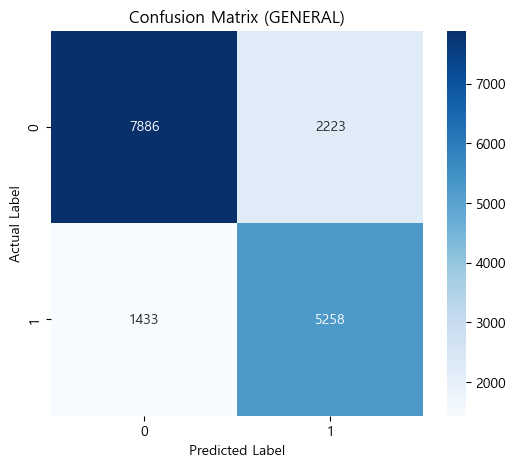

<Figure size 1000x800 with 0 Axes>

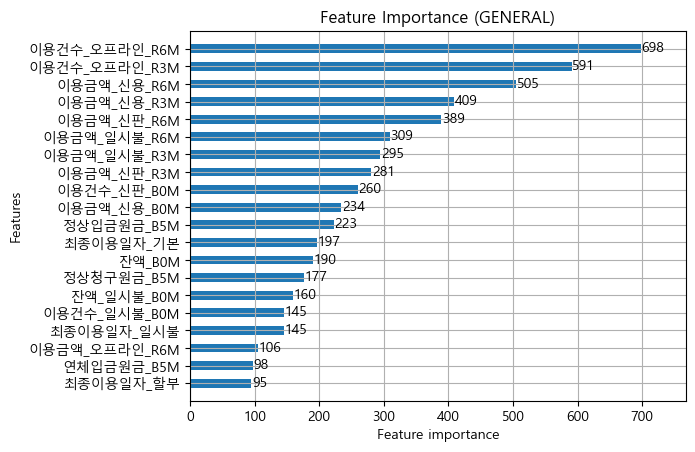

In [12]:

# 1. Process Data
# df_train_final = process_data_and_merge(TRAIN_FILE)

# 2. Train Model
if df_train_final is not None:
    model, res = train_eval_lgbm_general_group_split(df_train_final)


### status score 2 이상으로 설정
- 분포 확인

In [13]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy.stats import linregress
import os
import tqdm  # For progress bar if available, else standard print

# =============================================================================
# [설정] 컬럼명 및 파일 경로 설정
# =============================================================================
COL_ID = '발급회원번호'
COL_DATE = '기준년월'

# 분석 변수 (Wide Format의 접미사 '_MM' 등을 뗀 순수 컬럼명 가정)
COL_SPEND = '이용금액_신용_B0M'      # 소비
COL_COUNT = '이용건수_신용_B0M'      # 빈도
COL_BALANCE = '잔액_B0M'             # 잔액
COL_CASH_ADV = '잔액_현금서비스_B0M' # 악성부채1
COL_CARD_LOAN = '잔액_카드론_B0M'    # 악성부채2
COL_DELINQ = '연체잔액_B0M'          # 리스크3
COL_AVG_BAL = '월중평잔'             # 자산

def calc_slope_long(series):
    """시계열 데이터(Series)의 선형 회귀 기울기를 계산"""
    y = series.values.astype(float)
    if len(y) < 2 or np.sum(y) == 0:
        return 0
    x = np.arange(len(y))
    slope, _, _, _, _ = linregress(x, y)
    return 0 if np.isnan(slope) else slope

# Additional columns for R12M fallback
COL_SPEND_R12M = '이용금액_신용_R12M'
COL_COUNT_R12M = '이용건수_신용_R12M'

def calculate_churn_scores(group):
    """고객 한 명의 데이터를 받아 점수 및 Target 생성 (1개월 이상 데이터 필요)"""
    # 데이터가 아예 없는 경우
    if len(group) < 1:
        return pd.Series({
            'Score_BadDebt': 0, 'Score_Delinq': 0, 'Score_Activity': 0, 'Score_Asset': 0,
            'Score_Status_Total': 0, 'Slope_Spend': 0, 'Slope_Balance': 0, 'Slope_Count': 0
        })

    # (A) 상태 점수 (Status Score) 세부 항목 계산
    try:
        # Helper for safe indexing
        def get_val(col, idx_from_last):
            # idx_from_last: 1 for last, 2 for 2nd last...
            if len(group) >= idx_from_last:
                return group[col].iloc[-idx_from_last]
            return 0

        # 1. [부정] 악성 부채 점수 (Score_BadDebt)
        # If only 1 month, cannot compare with previous, so score is 0
        val_last = get_val(COL_CASH_ADV, 1)
        val_prev = get_val(COL_CASH_ADV, 2)
        
        loan_last = get_val(COL_CARD_LOAN, 1)
        loan_prev = get_val(COL_CARD_LOAN, 2)
        
        bad_debt_score = (
            ((val_last - val_prev) / (val_prev + 1) * 1.5) +
            ((loan_last - loan_prev) / (loan_prev + 1) * 1.0)
        )
        
        # 2. [부정] 연체 강도 점수 (Score_Delinq)
        delinq_score = (get_val(COL_DELINQ, 1) * 3.0) + (get_val(COL_DELINQ, 2) * 2.0)
        if len(group) >= 3:
            delinq_score += (get_val(COL_DELINQ, 3) * 1.0)
        
        # 3. [긍정] 활동성 점수 (Score_Activity)
        sum_r3 = group[COL_COUNT].iloc[-3:].sum()
        sum_r6 = group[COL_COUNT].sum()
        activity_score = ((sum_r3 * 2) - sum_r6) / (sum_r6 + 1) * 100
        
        # 4. [긍정] 자산 방어 점수 (Score_Asset)
        avg_r3 = group[COL_AVG_BAL].iloc[-3:].mean()
        avg_r6 = group[COL_AVG_BAL].mean()
        asset_score = (avg_r3 / (avg_r6 + 1)) * 10
        
        # >> [Total] 상태 종합 점수 (Score_Status_Total)
        score_status_total = (bad_debt_score + delinq_score) - (activity_score + asset_score)
    except:
        bad_debt_score = 0
        delinq_score = 0
        activity_score = 0
        asset_score = 0
        score_status_total = 0

    # (B) 기울기 점수 (Slope Score)
    # CASE 1: Data >= 2 months (Use linregress)
    if len(group) >= 2:
        slope_spend = calc_slope_long(group[COL_SPEND])
        slope_balance = calc_slope_long(group[COL_BALANCE])
        slope_count = calc_slope_long(group[COL_COUNT])
    
    # CASE 2: Data == 1 month (Use R12M fallback)
    else:
        # Spending Slope Proxy: Current - Monthly_Avg(R12M)
        # If current < avg, result is negative (decrease) -> Condition met
        # If current > avg, result is positive (increase) -> Condition failed
        r12m_spend = group[COL_SPEND_R12M].iloc[0] if COL_SPEND_R12M in group.columns else 0
        avg_spend = r12m_spend / 12
        slope_spend = group[COL_SPEND].iloc[0] - avg_spend
        
        # Count Slope Proxy
        r12m_count = group[COL_COUNT_R12M].iloc[0] if COL_COUNT_R12M in group.columns else 0
        avg_count = r12m_count / 12
        slope_count = group[COL_COUNT].iloc[0] - avg_count
        
        # Balance Slope: User requested to exclude this (always satisfy).
        # We set it to -1 (or any value <= 0) to ensure the condition (slope <= 0) passes.
        slope_balance = -1

    return pd.Series({
        'Score_BadDebt': bad_debt_score,
        'Score_Delinq': delinq_score,
        'Score_Activity': activity_score,
        'Score_Asset': asset_score,
        'Score_Status_Total': score_status_total,
        'Slope_Spend': slope_spend,
        'Slope_Balance': slope_balance,
        'Slope_Count': slope_count
    })

def check_churn_condition(scores):
    """Calculates Target (1 or 0) from scores series"""
    # (조건 A) 기울기 3종(소비, 잔액, 건수)이 모두 0 이하
    cond_slopes_decrease = (
        (scores['Slope_Spend'] <= 0) & 
        (scores['Slope_Balance'] <= 0) & 
        (scores['Slope_Count'] <= 0)
    )
    
    # (조건 B) 4대 위험 징후 중 2개 이상 감지 (Risk_Count >= 2)
    cond1 = scores['Score_BadDebt'] > 0
    cond2 = scores['Score_Delinq'] > 0
    cond3 = scores['Score_Activity'] < 0
    cond4 = scores['Score_Asset'] == 0
    
    risk_count = int(cond1) + int(cond2) + int(cond3) + int(cond4)
    cond_high_risk = (risk_count >= 2)
    
    return 1 if (cond_slopes_decrease and cond_high_risk) else 0

def analyze_rolling_churn(file_path):
    print(f"\n[Info] 파일 로드 및 분석 시작: {file_path}")
    if not os.path.exists(file_path):
        print(f"❌ 파일을 찾을 수 없습니다: {file_path}")
        return

    # 1. Load Data
    try:
        df = pd.read_csv(file_path, low_memory=False)
        # Fill missing cols with 0 if needed
        # Added R12M columns to required list
        required_cols = [
            COL_ID, COL_DATE, COL_SPEND, COL_COUNT, COL_BALANCE, 
            COL_CASH_ADV, COL_CARD_LOAN, COL_DELINQ, COL_AVG_BAL,
            COL_SPEND_R12M, COL_COUNT_R12M
        ]
        for c in required_cols:
            if c not in df.columns: df[c] = 0
    except Exception as e:
        print(f"❌ 데이터 로드 실패: {e}")
        return

    # Sort
    df.sort_values(by=[COL_ID, COL_DATE], inplace=True)
    
    # Group by ID
    grouped = df.groupby(COL_ID)
    
    results = []
    
    print(" - 고객별 Rolling Analysis 진행 중... (데이터 최소 1개월 기준, 1개월 시 R12M 보완)")
    
    count_churners = 0
    total_processed = 0
    
    for cust_id, group in grouped:
        total_processed += 1
        # Minimum 1 months required logic now supported
        if len(group) < 1:
            continue
            
        # 1. "현재 시점"의 이탈 여부를 확인
        # (주의: 사용자가 원하는 것은 '현재 이탈자인 사람'의 과거 지속기간 확인이므로,
        # 가장 마지막 달이 Churn이어야 분석 대상이 됨)
        current_scores = calculate_churn_scores(group)
        is_current_churn = check_churn_condition(current_scores)
        
        if is_current_churn == 1:
            count_churners += 1
            
            # 2. 이탈자라면, 과거로 역추적 (Rolling)
            consecutive_months = 1 # Start with 1 (the current month)
            
            # Max lookback
            # If len=6, loops i=1 to 5 (check len=5 down to len=1)
            # If len=1, loop range(1, 1) -> Empty loop (correct, duration=1)
            max_lookback = len(group) - 1
            
            for i in range(1, max_lookback + 1):
                past_group = group.iloc[:-i] # Remove last i rows
                past_scores = calculate_churn_scores(past_group)
                is_past_churn = check_churn_condition(past_scores)
                
                if is_past_churn == 1:
                    consecutive_months += 1
                else:
                    break # Break chain
            
            results.append({
                'Cust_ID': cust_id,
                'Churn_Duration_Months': consecutive_months
            })
            
        # if total_processed % 1000 == 0:
        #     print(f"   ... {total_processed}명 처리 완료 (발견된 이탈자: {count_churners}명)")

    # Output Results
    if len(results) == 0:
        print("❌ 분석된 이탈자가 없습니다.")
        return

    df_res = pd.DataFrame(results)
    
    print("\n" + "="*50)
    print(f"📊 이탈자 Rolling 분석 결과 (대상 파일: {os.path.basename(file_path)})")
    print("="*50)
    print(f" - 총 분석 고객 수: {total_processed}명")
    print(f" - 최종 시점 이탈자 수: {len(df_res)}명 ({len(df_res)/total_processed*100:.2f}%)")
    print("-" * 30)
    print(" [이탈 징후 지속 기간 통계]")
    print(df_res['Churn_Duration_Months'].describe())
    print("-" * 30)
    print(" [기간별 분포 (상위 10개)]")
    print(df_res['Churn_Duration_Months'].value_counts().sort_index(ascending=False).head(10))
    
    # Save detailed results
    save_path = f"churn_duration_results_{os.path.basename(file_path)}"
    # df_res.to_csv(save_path, index=False)
    print(f"\n✅ 상세 결과 저장 완료: {save_path}")



In [14]:

analyze_rolling_churn(TEST_FILE)


[Info] 파일 로드 및 분석 시작: ../../../260108/general_combined_part1.csv
 - 고객별 Rolling Analysis 진행 중... (데이터 최소 1개월 기준, 1개월 시 R12M 보완)


C:\Users\johnh\AppData\Local\Temp\ipykernel_27772\2375762321.py:75: RuntimeWarning: divide by zero encountered in scalar divide
  activity_score = ((sum_r3 * 2) - sum_r6) / (sum_r6 + 1) * 100



📊 이탈자 Rolling 분석 결과 (대상 파일: general_combined_part1.csv)
 - 총 분석 고객 수: 84000명
 - 최종 시점 이탈자 수: 5178명 (6.16%)
------------------------------
 [이탈 징후 지속 기간 통계]
count    5178.000000
mean        1.661452
std         0.740339
min         1.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         5.000000
Name: Churn_Duration_Months, dtype: float64
------------------------------
 [기간별 분포 (상위 10개)]
Churn_Duration_Months
5       1
4       1
3     830
2    1758
1    2588
Name: count, dtype: int64

✅ 상세 결과 저장 완료: churn_duration_results_general_combined_part1.csv
